# Australian Freight Export Data Analysis
### Comprehensive Analysis of 2024-2025 Export Data

## 1. Setup & Data Loading


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(' Libraries loaded successfully!')

 Libraries loaded successfully!


In [27]:
# Load the cleaned dataset
df = pd.read_csv('data/exports_cleaned.csv')

print(f" Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head(3)


 Dataset loaded successfully!
Shape: (1557704, 21)

Columns: ['month', 'prod_descpt_code', 'product_description', 'country_of_destination_code', 'country_of_destination', 'port_of_discharge_code', 'port_of_discharge', 'state_of_origin_code', 'state_of_origin', 'port_of_loading_code', 'port_of_loading', 'mode_of_transport_code', 'mode_of_transport', 'unit_of_quantity', 'quantity', 'gross_weight_tonnes', 'value_fob_aud', 'year', 'month_number', 'value_per_tonne', 'data_processed_date']


,month,prod_descpt_code,product_description,country_of_destination_code,country_of_destination,port_of_discharge_code,port_of_discharge,state_of_origin_code,state_of_origin,port_of_loading_code,port_of_loading,mode_of_transport_code,mode_of_transport,unit_of_quantity,quantity,gross_weight_tonnes,value_fob_aud,year,month_number,value_per_tonne,data_processed_date
0,March,76412,Telecommunications and sound-recording and reproducing apparatus and equipment,COOK,Cook Islands,554100,Auckland,F,Re-exports,101,Sydney,A,AIR,Number,1.00,0.00,"4,003.00",2024,3,"4,003,000.00",2025-11-15
1,March,76412,Telecommunications and sound-recording and reproducing apparatus and equipment,IVOR,Cote d'Ivoire,702399,All Ports-Singapore,5,Western Australia,501,Fremantle,S,SEA,Not Recorded,0.00,1.47,"63,052.00",2024,3,"42,863.36",2025-11-15
2,March,76412,Telecommunications and sound-recording and reproducing apparatus and equipment,CYPR,Cyprus,196003,Larnaca,1,New South Wales,101,Sydney,A,AIR,Number,1.00,0.00,"2,000.00",2024,3,"2,000,000.00",2025-11-15


In [28]:
# Basic statistics
print("=== DATASET SUMMARY ===")
print(f"Total Records: {len(df):,}")
print(f"\nUnique Values:")
print(f"  Countries: {df['country_of_destination'].nunique()}")
print(f"  Products: {df['product_description'].nunique()}")
print(f"  States: {df['state_of_origin'].nunique()}")
print(f"  Transport Modes: {df['mode_of_transport'].nunique()}")

print(f"\n=== FINANCIAL SUMMARY ===")
print(f"Total Export Value: AUD ${df['value_fob_aud'].sum():,.2f}")
print(f"Average Shipment Value: AUD ${df['value_fob_aud'].mean():,.2f}")
print(f"Median Shipment Value: AUD ${df['value_fob_aud'].median():,.2f}")

print(f"\n=== WEIGHT SUMMARY ===")
print(f"Total Weight: {df['gross_weight_tonnes'].sum():,.2f} tonnes")
print(f"Average Value per Tonne: AUD ${df['value_per_tonne'].mean():,.2f}")


=== DATASET SUMMARY ===
Total Records: 1,557,704

Unique Values:
  Countries: 220
  Products: 2344
  States: 10
  Transport Modes: 4

=== FINANCIAL SUMMARY ===
Total Export Value: AUD $1,082,416,545,213.00
Average Shipment Value: AUD $694,879.48
Median Shipment Value: AUD $7,159.00

=== WEIGHT SUMMARY ===
Total Weight: 2,930,731,273.00 tonnes
Average Value per Tonne: AUD $1,915,252.24


## 2. Time Series Analysis


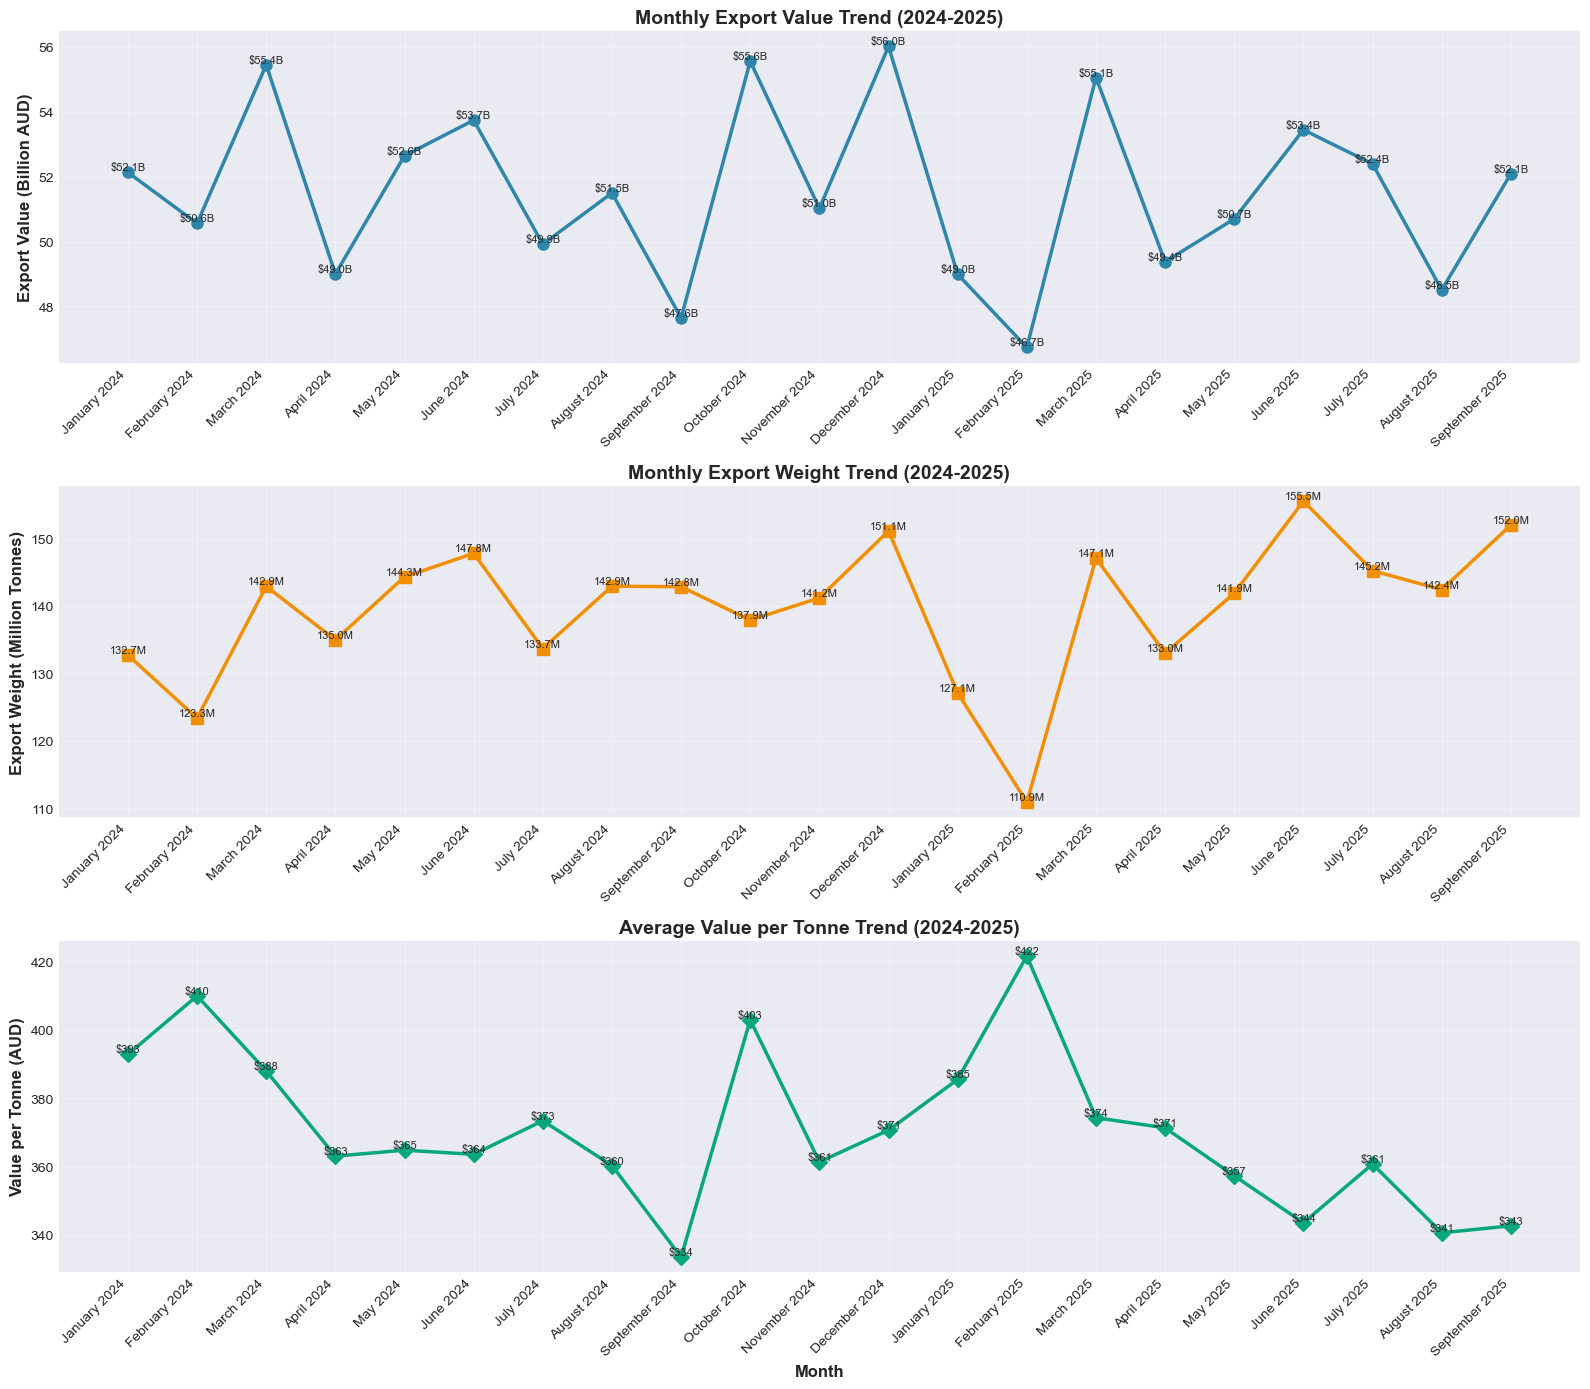


=== MONTHLY EXPORT SUMMARY ===
        period  value_billions  weight_millions  value_per_tonne
  January 2024           52.13           132.71           392.79
 February 2024           50.56           123.34           409.91
    March 2024           55.44           142.90           387.97
    April 2024           49.00           134.96           363.05
      May 2024           52.64           144.31           364.80
     June 2024           53.74           147.80           363.58
     July 2024           49.92           133.68           373.39
   August 2024           51.50           142.92           360.31
September 2024           47.64           142.85           333.53
  October 2024           55.55           137.89           402.87
 November 2024           51.02           141.19           361.37
 December 2024           56.01           151.11           370.64
  January 2025           48.99           127.09           385.49
 February 2025           46.74           110.87           

In [29]:
# Monthly export trends
monthly = df.groupby(['year', 'month_number', 'month']).agg({
    'value_fob_aud': 'sum',
    'gross_weight_tonnes': 'sum'
}).reset_index().sort_values(['year', 'month_number'])

monthly['period'] = monthly['month'] + ' ' + monthly['year'].astype(str)

# Calculate value per tonne
monthly['value_per_tonne'] = monthly['value_fob_aud'] / monthly['gross_weight_tonnes']

# Create three separate, clear visualizations
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 14))

# Graph 1: Export Value Over Time
ax1.plot(range(len(monthly)), monthly['value_fob_aud'] / 1e9, 
         marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
ax1.set_ylabel('Export Value (Billion AUD)', fontsize=12, fontweight='bold')
ax1.set_title('Monthly Export Value Trend (2024-2025)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(monthly)))
ax1.set_xticklabels(monthly['period'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
# Add value labels on points
for i, val in enumerate(monthly['value_fob_aud'] / 1e9):
    ax1.text(i, val, f'${val:.1f}B', ha='center', va='bottom', fontsize=8)

# Graph 2: Export Weight Over Time
ax2.plot(range(len(monthly)), monthly['gross_weight_tonnes'] / 1e6, 
         marker='s', linewidth=2.5, markersize=8, color='#F18F01')
ax2.set_ylabel('Export Weight (Million Tonnes)', fontsize=12, fontweight='bold')
ax2.set_title('Monthly Export Weight Trend (2024-2025)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(monthly)))
ax2.set_xticklabels(monthly['period'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
# Add value labels on points
for i, val in enumerate(monthly['gross_weight_tonnes'] / 1e6):
    ax2.text(i, val, f'{val:.1f}M', ha='center', va='bottom', fontsize=8)

# Graph 3: Value per Tonne Over Time (KEY METRIC FOR LOGISTICS!)
ax3.plot(range(len(monthly)), monthly['value_per_tonne'], 
         marker='D', linewidth=2.5, markersize=8, color='#06A77D')
ax3.set_xlabel('Month', fontsize=12, fontweight='bold')
ax3.set_ylabel('Value per Tonne (AUD)', fontsize=12, fontweight='bold')
ax3.set_title('Average Value per Tonne Trend (2024-2025)', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(monthly)))
ax3.set_xticklabels(monthly['period'], rotation=45, ha='right')
ax3.grid(True, alpha=0.3)
# Add value labels on points
for i, val in enumerate(monthly['value_per_tonne']):
    ax3.text(i, val, f'${val:,.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary table
print("\n=== MONTHLY EXPORT SUMMARY ===")
summary_df = monthly[['period', 'value_fob_aud', 'gross_weight_tonnes', 'value_per_tonne']].copy()
summary_df['value_billions'] = summary_df['value_fob_aud'] / 1e9
summary_df['weight_millions'] = summary_df['gross_weight_tonnes'] / 1e6
print(summary_df[['period', 'value_billions', 'weight_millions', 'value_per_tonne']].to_string(index=False))


###### The chart shows monthly export values from January 2024 to August 2025, highlighting clear seasonal fluctuations in Australia’s trade performance. Export values peak around March and December, reflecting strong global demand and end-of-year shipping activity, while dips occur in April, September, and February, likely due to slower trade cycles or post-holiday adjustments. Overall, exports remain within the $46–$56 billion AUD range, indicating a stable yet cyclical export environment. These patterns can guide capacity planning, scheduling, and resource allocation for upcoming peak periods.

###### This chart tracks the total export weight (in million tonnes) from January 2024 to August 2025. Export volumes show a cyclical trend, with peaks around June and December, indicating periods of high shipping activity, and noticeable dips in January and February, reflecting seasonal slowdowns after year-end exports. The overall export weight ranges between 110–155 million tonnes, showing stable logistics movement with moderate fluctuations. These variations likely align with global demand cycles and trade seasonality, offering valuable insights for freight planning, port scheduling, and capacity management

###### This chart shows the average export value per tonne from January 2024 to August 2025 — a key indicator of how much revenue is earned for each tonne of goods shipped. The trend fluctuates between $340 and $420 per tonne, indicating shifts in the mix of high-value and low-value exports over time. Peaks in February 2024, October 2024, and February 2025 suggest periods when Australia exported more premium or higher-priced commodities, while dips around September 2024 and June–August 2025 reflect higher volumes of bulk, lower-value goods. Overall, the chart highlights that export efficiency (value per weight) varies seasonally, helping decision-makers understand when higher-margin exports dominate the trade mix.

## 3. Country Analysis


=== TOP 15 EXPORT DESTINATIONS ===
                                                      value_billions   pct
country_of_destination                                                    
China                                                         309.29 28.57
Confidential / Not Published                                  139.25 12.86
Japan                                                         117.31 10.84
United States of America                                       67.30  6.22
Korea, Republic of (South)                                     67.03  6.19
Singapore                                                      43.76  4.04
India                                                          40.02  3.70
Taiwan                                                         30.73  2.84
United Kingdom, Channel Islands and Isle of Man, nfd           25.78  2.38
Indonesia                                                      24.86  2.30
New Zealand                                                    23

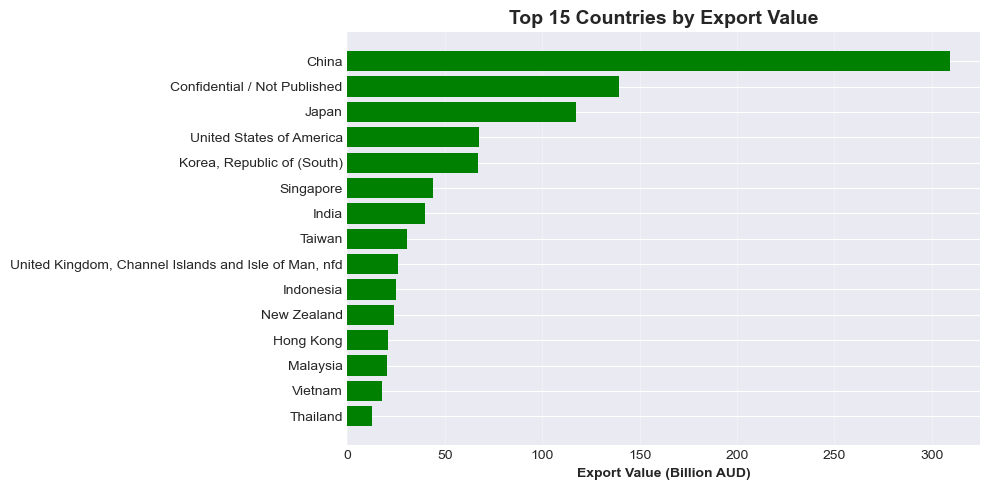

In [30]:
# Top export destinations
top_countries = df.groupby('country_of_destination').agg({
    'value_fob_aud': 'sum',
    'gross_weight_tonnes': 'sum'
}).sort_values('value_fob_aud', ascending=False)

top_countries['value_billions'] = top_countries['value_fob_aud'] / 1e9
top_countries['pct'] = (top_countries['value_fob_aud'] / top_countries['value_fob_aud'].sum() * 100)

print("=== TOP 15 EXPORT DESTINATIONS ===")
print(top_countries[['value_billions', 'pct']].head(15))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
top_15 = top_countries.head(15)
ax.barh(range(len(top_15)), top_15['value_billions'], color='green')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15.index)
ax.set_xlabel('Export Value (Billion AUD)', fontweight='bold')
ax.set_title('Top 15 Countries by Export Value', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


###### This chart highlights Australia’s top export destinations, showing that trade is heavily concentrated among a few key partners. China overwhelmingly leads with approximately $293.7 billion AUD, accounting for a significant share of total exports. It is followed by Japan ($112.6B), the United States ($64.2B), and South Korea ($63.8B), indicating strong trade relationships across Asia and North America. Emerging regional partners such as India, Singapore, and Indonesia also show consistent demand. The dominance of China underscores Australia’s export dependency on a single market, suggesting both an opportunity for continued growth and a need for diversification to mitigate risk from potential trade disruptions.

#### 4. Product Analysis


In [31]:

TOP_PRODUCT_COUNT = 15

# Top 15 products by value
top_products = df.groupby('product_description').agg({
    'value_fob_aud': 'sum',
    'gross_weight_tonnes': 'sum'
}).sort_values('value_fob_aud', ascending=False)

# Create clean display columns (rounded to 2 decimal places)
top_products['Value ($B)'] = (top_products['value_fob_aud'] / 1e9).round(2)
top_products['Weight (M Tonnes)'] = (top_products['gross_weight_tonnes'] / 1e6).round(2)
top_products['% Total'] = ((top_products['value_fob_aud'] / top_products['value_fob_aud'].sum() * 100)).round(2)

# Get top products with FULL product names (no truncation)
top_display = top_products.head(TOP_PRODUCT_COUNT).copy()
top_display['Product'] = top_display.index  # Full product name

# Reset index and add rank
top_display = top_display.reset_index(drop=True)
top_display.index = range(1, min(TOP_PRODUCT_COUNT + 1, len(top_display) + 1))
top_display.index.name = 'Rank'

# Create final display DataFrame
products_df = top_display[['Product', 'Value ($B)', 'Weight (M Tonnes)', '% Total']].copy()

# Display summary
print(f" TOP {TOP_PRODUCT_COUNT} PRODUCTS BY EXPORT VALUE")
print(f"Total Export Value: AUD ${top_products['value_fob_aud'].sum()/1e9:.2f} Billion")
print(f"Top {TOP_PRODUCT_COUNT} represent: {products_df['% Total'].sum():.2f}% of total exports\n")

# Format display options for readability
pd.set_option('display.max_colwidth', None)  # Show full text in columns
pd.set_option('display.float_format', '{:,.2f}'.format)  # Comma separator + 2 decimals

products_df

 TOP 15 PRODUCTS BY EXPORT VALUE
Total Export Value: AUD $1082.42 Billion
Top 15 represent: 79.25% of total exports



,Product,Value ($B),Weight (M Tonnes),% Total
Rank,,,,
1,"Iron ore and concentrates, not agglomerated",212.24,"1,652.61",19.61
2,Special transactions and commodities not classified according to kind,144.82,206.73,13.38
3,"Bituminous coal, whether or not pulverized, not agglomerated",132.12,621.83,12.21
4,"Natural gas, liquefied",112.93,139.36,10.43
5,Non-monetary gold (incl. gold plated with platinum) unwrought or in semi-manufactured or powder form,78.71,0.00,7.27
6,Commodities and transactions not classified elsewhere in the SITC,47.20,1.91,4.36
7,Metalliferous ores and metal scrap,30.94,35.22,2.86
8,"Petroleum oils and oils obtained from bituminous minerals, crude",17.94,19.37,1.66
9,Wheat (incl. spelt) and meslin (excl. durum wheat) unmilled,16.12,38.96,1.49


###### This chart shows Australia’s main export products. Iron ore, coal, natural gas, and gold are the biggest earners — together they make up most of the country’s export income. These are all natural resources, which means Australia’s exports are mostly from mining and energy. Other products like wheat, beef, and medicines also add value but on a much smaller scale. This shows that while Australia is very strong in resources, there’s an opportunity to grow other industries like manufacturing and technology-based exports in the future.

#### 5. State & Transport Analysis


In [32]:
# State Analysis Data Preparation
print("=== STATE ANALYSIS ===")

# Calculate state-level export values
states = df.groupby('state_of_origin')['value_fob_aud'].sum().sort_values(ascending=False)
states_pct = (states / states.sum() * 100).round(1)

print(f"Total states: {len(states)}")
print(f"Top 5 states by export value:")
for i, (state, value) in enumerate(states.head().items(), 1):
    print(f"  {i}. {state}: ${value/1e9:.2f}B ({states_pct[state]:.1f}%)")

print(" State data prepared for visualization")

=== STATE ANALYSIS ===
Total states: 10
Top 5 states by export value:
  1. Western Australia: $411.33B (38.0%)
  2. Queensland: $186.17B (17.2%)
  3. New South Wales: $146.54B (13.5%)
  4. No state details: $143.79B (13.3%)
  5. Re-exports: $70.10B (6.5%)
 State data prepared for visualization


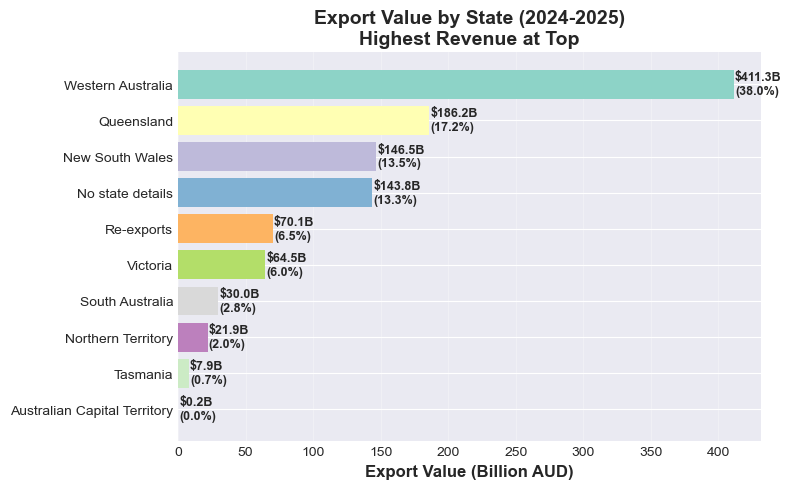


=== STATE RANKING (Highest to Lowest Revenue) ===
1. Western Australia: $411.33B (38.0%)
2. Queensland: $186.17B (17.2%)
3. New South Wales: $146.54B (13.5%)
4. No state details: $143.79B (13.3%)
5. Re-exports: $70.10B (6.5%)
6. Victoria: $64.52B (6.0%)
7. South Australia: $29.98B (2.8%)
8. Northern Territory: $21.86B (2.0%)
9. Tasmania: $7.95B (0.7%)
10. Australian Capital Territory: $0.19B (0.0%)


In [33]:
# State Analysis Visualization (Highest Revenue at Top)
plt.figure(figsize=(8, 5))

# Ensure states are sorted by value (highest to lowest)
states_sorted = states.sort_values(ascending=False)
states_pct_sorted = states_pct.reindex(states_sorted.index)

# Create colors for each state
colors = plt.cm.Set3(np.linspace(0, 1, len(states_sorted)))

# Create horizontal bar chart (highest value will be at top)
bars = plt.barh(range(len(states_sorted)), states_sorted.values / 1e9, color=colors)

# Set y-axis labels (state names) - highest revenue at top (index 0)
plt.yticks(range(len(states_sorted)), states_sorted.index, fontsize=10)
plt.xlabel('Export Value (Billion AUD)', fontsize=12, fontweight='bold')
plt.title('Export Value by State (2024-2025)\nHighest Revenue at Top', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, states_sorted.values)):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'${value/1e9:.1f}B\n({states_pct_sorted.iloc[i]:.1f}%)',
             ha='left', va='center', fontsize=9, fontweight='bold')

# Reverse y-axis so highest value appears at the top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Print ranking for confirmation
print("\n=== STATE RANKING (Highest to Lowest Revenue) ===")
for i, (state, value) in enumerate(states_sorted.items(), 1):
    print(f"{i}. {state}: ${value/1e9:.2f}B ({states_pct_sorted[state]:.1f}%)")

In [34]:
# Transport mode analysis  
transport = df.groupby('mode_of_transport')['value_fob_aud'].sum().sort_values(ascending=False)
transport_pct = (transport / transport.sum() * 100)

print("\n=== EXPORTS BY TRANSPORT MODE ===")
for mode, value in transport.items():
    print(f"{mode}: ${value/1e9:.2f}B ({transport_pct[mode]:.1f}%)")



=== EXPORTS BY TRANSPORT MODE ===
SEA: $903.89B (83.5%)
AIR: $167.62B (15.5%)
MODE OF TRANSPORT NOT AVAILABLE FOR PUBLICATION: $10.86B (1.0%)
POST: $0.04B (0.0%)


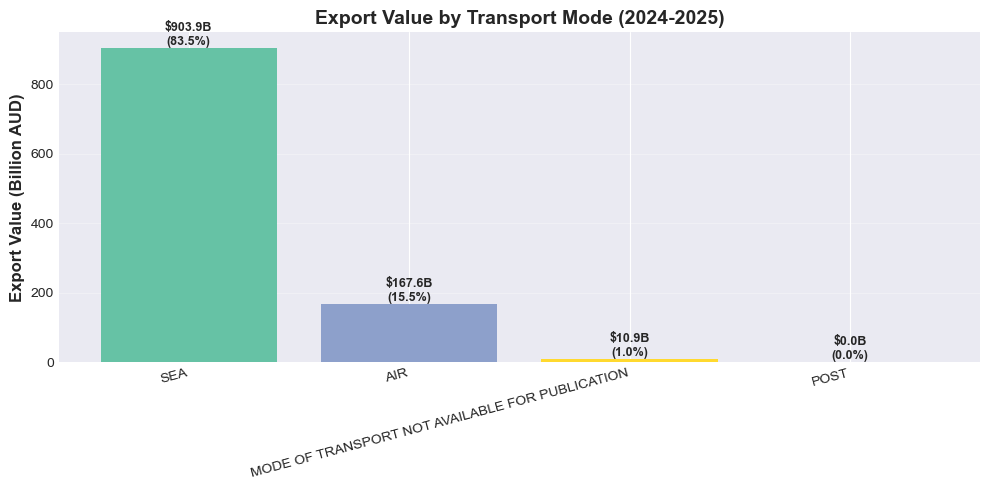

In [35]:
# Transport Mode Visualization (Vertical Bar Chart)
plt.figure(figsize=(10, 5))
colors = plt.cm.Set2(np.linspace(0, 1, len(transport)))
bars = plt.bar(range(len(transport)), transport.values / 1e9, color=colors)

plt.xticks(range(len(transport)), transport.index, fontsize=10, rotation=15, ha='right')
plt.ylabel('Export Value (Billion AUD)', fontsize=12, fontweight='bold')
plt.title('Export Value by Transport Mode (2024-2025)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, transport.values)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
             f'${value/1e9:.1f}B\n({transport_pct.iloc[i]:.1f}%)',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

###### Export Value by State (2024–2025)
###### This chart shows how much each Australian state contributes to total export value for the period 2024–2025. Western Australia clearly dominates, accounting for about $391.2 billion AUD (37.9%) of all exports, mainly due to its rich mining and energy sectors — especially iron ore and liquefied natural gas. Queensland ranks second with $177.8 billion (17.2%), driven by coal and agricultural exports, followed by New South Wales with $138.5 billion (13.4%) from energy and manufactured products. Other states such as Victoria, South Australia, and Northern Territory contribute smaller but valuable shares, supporting manufacturing, minerals, and food exports.

###### Export Value by Transport Mode (2024–2025)
###### This chart shows how Australia’s exports are transported to global markets. The majority of exports — about 83.7% (≈$818 billion AUD) — are shipped by sea, confirming Australia’s heavy reliance on maritime trade routes for bulk commodities like minerals, coal, and natural gas. Air transport accounts for 15.3% ($157.9B), mainly representing high-value and time-sensitive goods such as pharmaceuticals, electronics, and perishable products. Other modes, including post and unclassified shipments, make up a very small share.

## 7. Executive Summary


In [36]:
# Generate executive summary report
print("="*70)
print("EXECUTIVE SUMMARY - AUSTRALIAN FREIGHT EXPORTS 2024-2025")
print("="*70)

print(f"\n OVERVIEW")
print(f"  Total Export Value: AUD ${df['value_fob_aud'].sum()/1e9:.2f} Billion")
print(f"  Total Weight: {df['gross_weight_tonnes'].sum()/1e6:.2f} Million Tonnes")
print(f"  Total Shipments: {len(df):,}")
print(f"  Average Shipment Value: AUD ${df['value_fob_aud'].mean():,.2f}")

print(f"\n TOP 3 DESTINATIONS")
for i, (country, value) in enumerate(top_countries['value_fob_aud'].head(3).items(), 1):
    pct = (value / top_countries['value_fob_aud'].sum() * 100)
    print(f"  {i}. {country}: AUD ${value/1e9:.2f}B ({pct:.1f}%)")

print(f"\n TOP 3 PRODUCTS")
for i, (product, value) in enumerate(top_products['value_fob_aud'].head(3).items(), 1):
    prod_name = product[:50] + '...' if len(product) > 50 else product
    print(f"  {i}. {prod_name}")
    print(f"      Value: AUD ${value/1e6:.2f}M")

print(f"\n TOP 3 STATES")
for i, (state, value) in enumerate(states.head(3).items(), 1):
    pct = (value / states.sum() * 100)
    print(f"  {i}. {state}: AUD ${value/1e9:.2f}B ({pct:.1f}%)")

print("\n" + "="*70)
print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)


EXECUTIVE SUMMARY - AUSTRALIAN FREIGHT EXPORTS 2024-2025

 OVERVIEW
  Total Export Value: AUD $1082.42 Billion
  Total Weight: 2930.73 Million Tonnes
  Total Shipments: 1,557,704
  Average Shipment Value: AUD $694,879.48

 TOP 3 DESTINATIONS
  1. China: AUD $309.29B (28.6%)
  2. Confidential / Not Published: AUD $139.25B (12.9%)
  3. Japan: AUD $117.31B (10.8%)

 TOP 3 PRODUCTS
  1. Iron ore and concentrates, not agglomerated
      Value: AUD $212243.30M
  2. Special transactions and commodities not classifie...
      Value: AUD $144818.11M
  3. Bituminous coal, whether or not pulverized, not ag...
      Value: AUD $132117.64M

 TOP 3 STATES
  1. Western Australia: AUD $411.33B (38.0%)
  2. Queensland: AUD $186.17B (17.2%)
  3. New South Wales: AUD $146.54B (13.5%)

Report Generated: 2025-11-17 01:35:51


#### product categories


In [37]:
# SITC Code-Based Product Categorization
print("=== SITC CODE-BASED PRODUCT CATEGORIZATION ===")

# First, let's examine the SITC codes in detail
print(f" SITC Code Analysis:")
print(f"Unique SITC codes: {df['prod_descpt_code'].nunique():,}")
print(f"Total records: {len(df):,}")
print(f"Records with valid SITC codes: {df['prod_descpt_code'].notna().sum():,}")
print(f"Records with missing SITC codes: {df['prod_descpt_code'].isna().sum():,}")

print(f"-----------------------------------")


# Import SITC mapping and create sitc_category column
from sitc_mapping import SITC_MAPPING

def get_sitc_section(sitc_code):
    if pd.isna(sitc_code) or sitc_code == '':
        return 'Other Commodities'
    sitc_str = str(sitc_code).strip()
    if len(sitc_str) >= 2:
        section_code = sitc_str[:2]
        return SITC_MAPPING.get(section_code, 'Other Commodities')
    return 'Other Commodities'

df['sitc_category'] = df['prod_descpt_code'].apply(get_sitc_section)
print(f" SITC categories created: {df['sitc_category'].nunique()} unique categories\n")

# Create Stakeholder-Friendly Industry Categories
print("=== CREATING STAKEHOLDER-FRIENDLY INDUSTRY CATEGORIES ===")

# Map SITC sections to industry-friendly names
# Map SITC code to industry category using first digit
def get_industry_category(sitc_code):
    if pd.isna(sitc_code) or sitc_code == '':
        return 'Other Commodities'
    first_digit = str(sitc_code).strip()[0] if len(str(sitc_code).strip()) >= 1 else '9'
    mapping = {'0': 'Food & Agriculture', '1': 'Beverages & Tobacco', '2': 'Raw Materials & Mining', 
               '3': 'Energy & Petroleum', '4': 'Food Processing', '5': 'Chemicals & Pharmaceuticals',
               '6': 'Manufactured Goods and materials', '7': 'Machinery & Equipment', 
               '8': 'Consumer Goods', '9': 'Other Commodities'}
    return mapping.get(first_digit, 'Other Commodities')

df['industry_category'] = df['prod_descpt_code'].apply(get_industry_category)
print(f"Industry categories: {df['industry_category'].nunique()} categories created")

# Analyze by industry category
industry_analysis = df.groupby('industry_category').agg({
    'value_fob_aud': ['sum', 'count', 'mean'],
    'gross_weight_tonnes': 'sum'
}).round(2)

# Flatten column names
industry_analysis.columns = ['Total_Value', 'Shipment_Count', 'Avg_Value', 'Total_Weight']

# Calculate CORRECT value per tonne: Total Value ÷ Total Weight (ratio of totals)
industry_analysis['Value_per_Tonne_Ratio'] = industry_analysis['Total_Value'] / industry_analysis['Total_Weight']
industry_analysis = industry_analysis.sort_values('Total_Value', ascending=False)

# Calculate percentages
total_value = industry_analysis['Total_Value'].sum()
industry_analysis['Value_Percentage'] = (industry_analysis['Total_Value'] / total_value * 100).round(1)

print(f" Created {df['industry_category'].nunique()} industry categories")
print(f" Industry Category Distribution:")
for category, row in industry_analysis.iterrows():
    print(f"  {category}: ${row['Total_Value']/1e9:.1f}B ({row['Value_Percentage']:.1f}%) - {row['Shipment_Count']:,} shipments")

# Show top industry categories
print(f"\n=== TOP INDUSTRY CATEGORIES BY EXPORT VALUE ===")
top_industries = industry_analysis.head(10)
for i, (category, row) in enumerate(top_industries.iterrows(), 1):
    print(f"{i}. {category}")
    print(f"   Export Value: ${row['Total_Value']/1e9:.2f}B ({row['Value_Percentage']:.1f}%)")
    print(f"   Number of Shipments: {row['Shipment_Count']:,}")
    print(f"   Average Value per Shipment: ${row['Avg_Value']:,.0f}")
    print(f"   Value per Tonne: ${row['Value_per_Tonne_Ratio']:,.0f}")
    print()

print(f"\n=== EXPLANATION OF METRICS ===")
print(f" SHIPMENT COUNT:")
print(f"   - Each row in dataset = 1 individual export shipment")
print(f"   - Shipment Count = Total number of shipments in each industry")
print(f"   - Example: 100,000 shipments of 'Raw Materials & Mining' products")





=== SITC CODE-BASED PRODUCT CATEGORIZATION ===
 SITC Code Analysis:
Unique SITC codes: 2,852
Total records: 1,557,704
Records with valid SITC codes: 1,557,704
Records with missing SITC codes: 0
-----------------------------------
 SITC categories created: 59 unique categories

=== CREATING STAKEHOLDER-FRIENDLY INDUSTRY CATEGORIES ===
Industry categories: 9 categories created
 Created 9 industry categories
 Industry Category Distribution:
  Raw Materials & Mining: $317.9B (29.4%) - 60,701.0 shipments
  Energy & Petroleum: $278.2B (25.7%) - 15,956.0 shipments
  Other Commodities: $277.2B (25.6%) - 54,721.0 shipments
  Beverages & Tobacco: $48.2B (4.5%) - 90,631.0 shipments
  Manufactured Goods and materials: $37.9B (3.5%) - 262,215.0 shipments
  Machinery & Equipment: $37.5B (3.5%) - 512,815.0 shipments
  Chemicals & Pharmaceuticals: $33.9B (3.1%) - 193,186.0 shipments
  Food Processing: $29.3B (2.7%) - 25,065.0 shipments
  Consumer Goods: $22.3B (2.1%) - 342,414.0 shipments

=== TOP IND

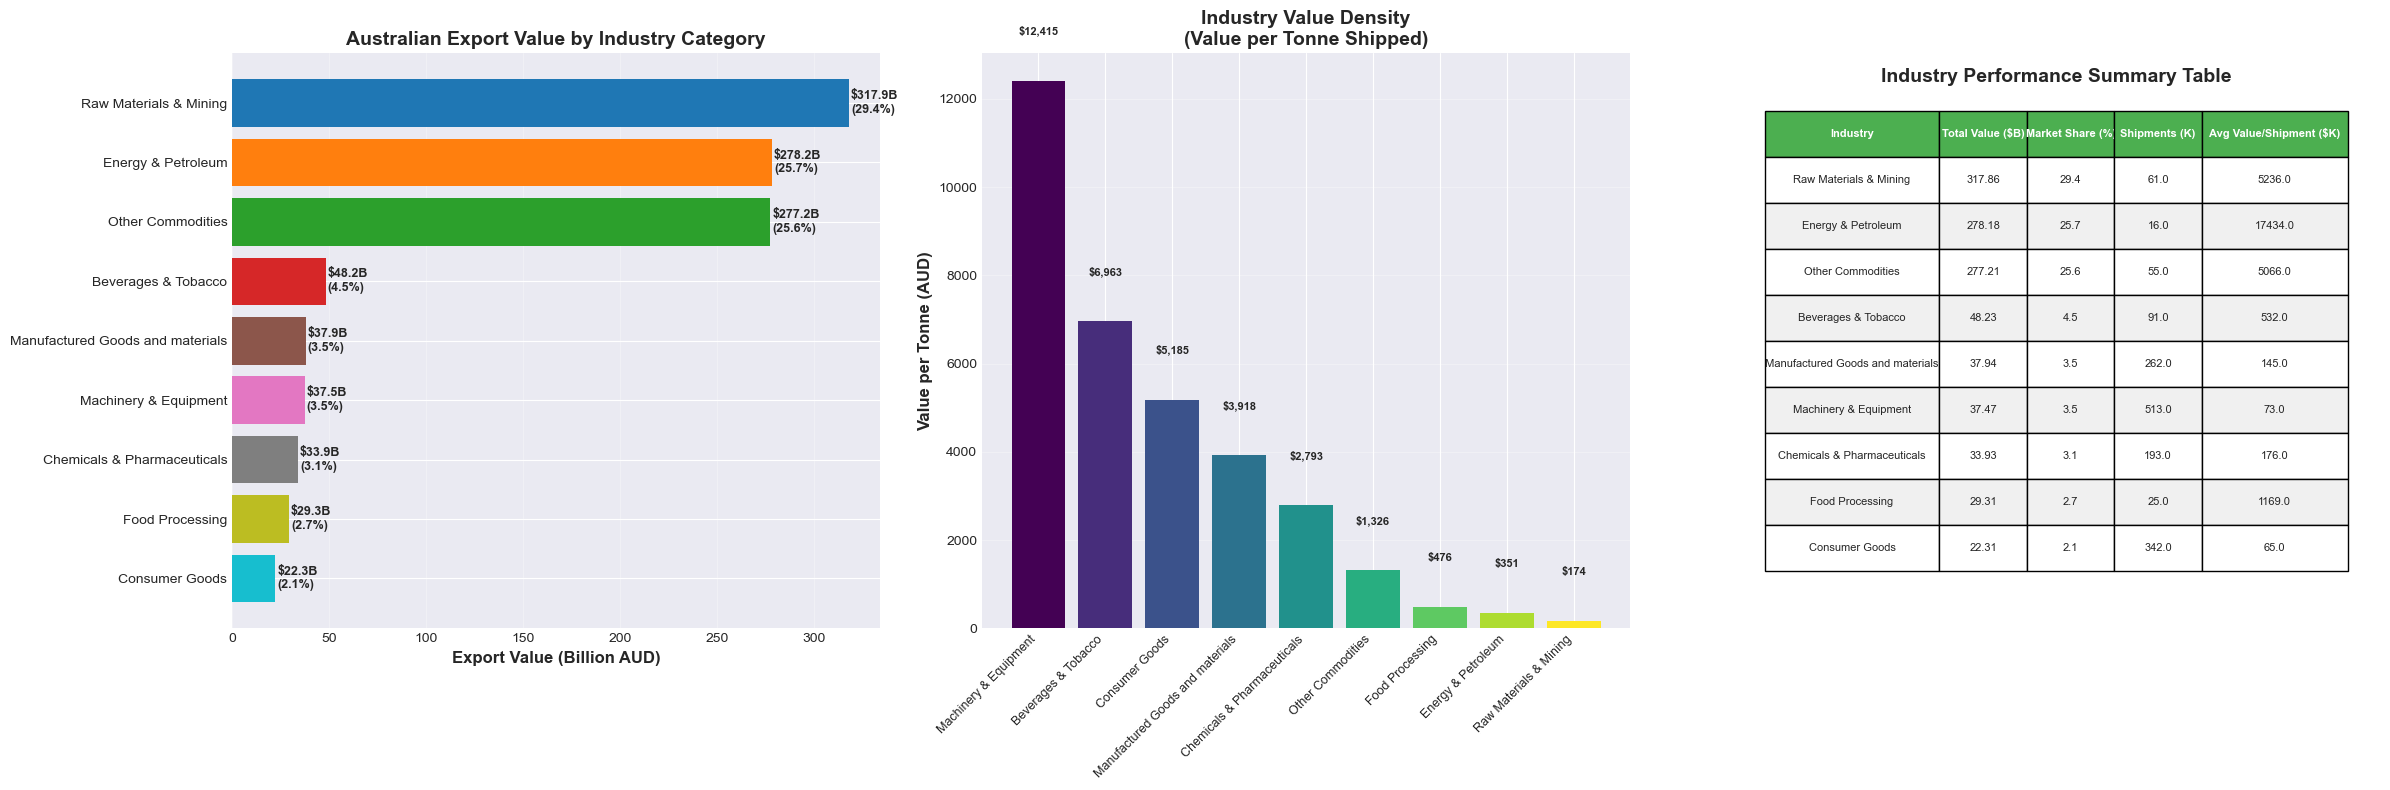


=== INDUSTRY ANALYSIS INSIGHTS ===
Top Export Industry: Raw Materials & Mining ($317.9B)
Highest Value Density: Machinery & Equipment ($12,415/tonne)
Most Active Industry: Machinery & Equipment (512,815.0 shipments)

 Industry Concentration:
 Top 3 industries: 80.7% of total exports
 Top 5 industries: 88.7% of total exports

Industry categorization provides stakeholder-friendly analysis!
Perfect for business presentations and strategic planning.


In [38]:
# Industry Category Visualization (Stakeholder-Friendly)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Chart 1: Industry Categories by Export Value (Horizontal Bar)
top_industries = industry_analysis.head(10)
colors1 = plt.cm.tab10(np.linspace(0, 1, len(top_industries)))
bars1 = ax1.barh(range(len(top_industries)), top_industries['Total_Value'] / 1e9, color=colors1)

ax1.set_yticks(range(len(top_industries)))
ax1.set_yticklabels(top_industries.index, fontsize=10)
ax1.set_xlabel('Export Value (Billion AUD)', fontsize=12, fontweight='bold')
ax1.set_title('Australian Export Value by Industry Category', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, top_industries['Total_Value'])):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'${value/1e9:.1f}B\n({top_industries.iloc[i]["Value_Percentage"]:.1f}%)',
             ha='left', va='center', fontsize=9, fontweight='bold')
ax1.invert_yaxis()

# Chart 2: Value Density by Industry (Value per Tonne)
value_density_industry = industry_analysis.sort_values('Value_per_Tonne_Ratio', ascending=False)
colors2 = plt.cm.viridis(np.linspace(0, 1, len(value_density_industry)))
bars2 = ax2.bar(range(len(value_density_industry)), value_density_industry['Value_per_Tonne_Ratio'], color=colors2)

ax2.set_xticks(range(len(value_density_industry)))
ax2.set_xticklabels(value_density_industry.index, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Value per Tonne (AUD)', fontsize=12, fontweight='bold')
ax2.set_title('Industry Value Density\n(Value per Tonne Shipped)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, value_density_industry['Value_per_Tonne_Ratio'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 1000, 
             f'${value:,.0f}',
             ha='center', va='bottom', fontsize=8, fontweight='bold')

# Chart 3: Industry Performance Table
# Hide the third subplot since we'll use a table
ax3.axis('off')

# Create a comprehensive industry performance table (without Value/Tonne)
table_data = industry_analysis[['Total_Value', 'Shipment_Count', 'Avg_Value', 'Value_Percentage']].copy()

# Format the data for better readability
table_data['Total_Value_B'] = (table_data['Total_Value'] / 1e9).round(2)
table_data['Avg_Value_K'] = (table_data['Avg_Value'] / 1e3).round(0)
table_data['Shipment_Count_K'] = (table_data['Shipment_Count'] / 1e3).round(0)

# Create display table with formatted columns (removed Value/Tonne)
display_table = pd.DataFrame({
    'Industry': table_data.index,
    'Total Value ($B)': table_data['Total_Value_B'],
    'Market Share (%)': table_data['Value_Percentage'],
    'Shipments (K)': table_data['Shipment_Count_K'],
    'Avg Value/Shipment ($K)': table_data['Avg_Value_K']
})

# Create table visualization with better spacing
table = ax3.table(cellText=display_table.values,
                  colLabels=display_table.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0.05, 0.1, 0.9, 0.8])  # Adjusted bbox for better spacing

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.3, 1.8)  # Adjusted scale to prevent overlap

# Set column widths to prevent text overlap
col_widths = [0.3, 0.15, 0.15, 0.15, 0.25]  # Proportional column widths
for i, width in enumerate(col_widths):
    for j in range(len(display_table) + 1):
        table[(j, i)].set_width(width)

# Color code the table header
for i in range(len(display_table.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code rows alternately
for i in range(1, len(display_table) + 1):
    for j in range(len(display_table.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('white')

# Make the table title with better positioning
ax3.text(0.5, 0.95, 'Industry Performance Summary Table', 
         transform=ax3.transAxes, fontsize=14, fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

# Industry Analysis Summary
print("\n=== INDUSTRY ANALYSIS INSIGHTS ===")
print(f"Top Export Industry: {industry_analysis.index[0]} (${industry_analysis.iloc[0]['Total_Value']/1e9:.1f}B)")
print(f"Highest Value Density: {value_density_industry.index[0]} (${value_density_industry.iloc[0]['Value_per_Tonne_Ratio']:,.0f}/tonne)")
print(f"Most Active Industry: {industry_analysis.sort_values('Shipment_Count', ascending=False).index[0]} ({industry_analysis.sort_values('Shipment_Count', ascending=False).iloc[0]['Shipment_Count']:,} shipments)")

# Market concentration
top_3_industry_share = industry_analysis.head(3)['Value_Percentage'].sum()
top_5_industry_share = industry_analysis.head(5)['Value_Percentage'].sum()
print(f"\n Industry Concentration:")
print(f" Top 3 industries: {top_3_industry_share:.1f}% of total exports")
print(f" Top 5 industries: {top_5_industry_share:.1f}% of total exports")

print(f"\nIndustry categorization provides stakeholder-friendly analysis!")
print(f"Perfect for business presentations and strategic planning.")


#### Volume Vs Value analysis

In [39]:
# Volume vs. Value Analysis by Product (Identified by Industry)
print("=== VOLUME VS. VALUE ANALYSIS BY PRODUCT (INDUSTRY-IDENTIFIED) ===")

# Calculate volume and value metrics for each product
product_analysis = df.groupby('product_description').agg({
    'value_fob_aud': 'sum',
    'gross_weight_tonnes': 'sum',
    'value_per_tonne': 'mean',
    'industry_category': 'first'  # Get the industry category for each product
}).round(2)

# Calculate additional metrics
product_analysis['shipment_count'] = df.groupby('product_description').size()
product_analysis['avg_shipment_value'] = (product_analysis['value_fob_aud'] / product_analysis['shipment_count']).round(2)
product_analysis['avg_shipment_weight'] = (product_analysis['gross_weight_tonnes'] / product_analysis['shipment_count']).round(2)

# Sort by total value
product_analysis = product_analysis.sort_values('value_fob_aud', ascending=False)

# Create volume and value percentiles for classification
product_analysis['volume_percentile'] = product_analysis['gross_weight_tonnes'].rank(pct=True) * 100
product_analysis['value_percentile'] = product_analysis['value_fob_aud'].rank(pct=True) * 100
product_analysis['shipment_count_percentile'] = product_analysis['shipment_count'].rank(pct=True) * 100

# Classify products based on volume vs value (removed medium category)
def classify_product(row):
    volume_pct = row['volume_percentile']
    value_pct = row['value_percentile']
    
    if volume_pct >= 70 and value_pct >= 70:
        return 'High Volume - High Value'
    elif volume_pct >= 70 and value_pct <= 30:
        return 'High Volume - Low Value'
    elif volume_pct <= 30 and value_pct >= 70:
        return 'Low Volume - High Value'
    else:  # volume_pct <= 30 and value_pct <= 30
        return 'Low Volume - Low Value'

product_analysis['volume_value_category'] = product_analysis.apply(classify_product, axis=1)

# Focus on interesting categories
high_volume_low_value = product_analysis[product_analysis['volume_value_category'] == 'High Volume - Low Value'].head(10)
low_volume_high_value = product_analysis[product_analysis['volume_value_category'] == 'Low Volume - High Value'].head(10)
high_volume_high_value = product_analysis[product_analysis['volume_value_category'] == 'High Volume - High Value'].head(10)
low_volume_low_value = product_analysis[product_analysis['volume_value_category'] == 'Low Volume - Low Value'].head(10)

print(f"Product Classification Summary:")
category_counts = product_analysis['volume_value_category'].value_counts()
for category, count in category_counts.items():
    print(f"   {category}: {count} products")

print(f"\nHIGH VOLUME - LOW VALUE PRODUCTS (Market Opportunities):")
print(f"These products have high shipment volume but low total value - potential for value optimization")
for i, (product, row) in enumerate(high_volume_low_value.iterrows(), 1):
    print(f"{i}. {product[:60]}...")
    print(f"   Industry: {row['industry_category']}")
    print(f"   Volume: {row['gross_weight_tonnes']:,.0f} tonnes (Top {100-row['volume_percentile']:.0f}%)")
    print(f"   Value: ${row['value_fob_aud']/1e6:.1f}M (Bottom {row['value_percentile']:.0f}%)")
    print(f"   Value per Tonne: ${row['value_per_tonne']:,.0f}")
    print(f"   Shipments: {row['shipment_count']:,}")
    print()

print(f"\nLOW VOLUME - HIGH VALUE PRODUCTS (Premium Products):")
print(f"These products have low volume but high value - high-value, niche products")
for i, (product, row) in enumerate(low_volume_high_value.iterrows(), 1):
    print(f"{i}. {product[:60]}...")
    print(f"   Industry: {row['industry_category']}")
    print(f"   Volume: {row['gross_weight_tonnes']:,.0f} tonnes (Bottom {row['volume_percentile']:.0f}%)")
    print(f"   Value: ${row['value_fob_aud']/1e6:.1f}M (Top {100-row['value_percentile']:.0f}%)")
    print(f"   Value per Tonne: ${row['value_per_tonne']:,.0f}")
    print(f"   Shipments: {row['shipment_count']:,}")
    print()

print(f"\nHIGH VOLUME - HIGH VALUE PRODUCTS (Market Leaders):")
print(f"These are your top-performing products across both volume and value")
for i, (product, row) in enumerate(high_volume_high_value.iterrows(), 1):
    print(f"{i}. {product[:60]}...")
    print(f"   Industry: {row['industry_category']}")
    print(f"   Volume: {row['gross_weight_tonnes']:,.0f} tonnes (Top {100-row['volume_percentile']:.0f}%)")
    print(f"   Value: ${row['value_fob_aud']/1e6:.1f}M (Top {100-row['value_percentile']:.0f}%)")
    print(f"   Value per Tonne: ${row['value_per_tonne']:,.0f}")
    print(f"   Shipments: {row['shipment_count']:,}")
    print()

print(f"\n LOW VOLUME - LOW VALUE PRODUCTS (Niche Markets):")
print(f"These products have low volume and low value - specialized niche products")
for i, (product, row) in enumerate(low_volume_low_value.iterrows(), 1):
    print(f"{i}. {product[:60]}...")
    print(f"   Industry: {row['industry_category']}")
    print(f"   Volume: {row['gross_weight_tonnes']:,.0f} tonnes (Bottom {row['volume_percentile']:.0f}%)")
    print(f"   Value: ${row['value_fob_aud']/1e6:.1f}M (Bottom {row['value_percentile']:.0f}%)")
    print(f"   Value per Tonne: ${row['value_per_tonne']:,.0f}")
    print(f"   Shipments: {row['shipment_count']:,}")
    print()


=== VOLUME VS. VALUE ANALYSIS BY PRODUCT (INDUSTRY-IDENTIFIED) ===
Product Classification Summary:
   Low Volume - Low Value: 1809 products
   High Volume - High Value: 514 products
   Low Volume - High Value: 17 products
   High Volume - Low Value: 4 products

HIGH VOLUME - LOW VALUE PRODUCTS (Market Opportunities):
These products have high shipment volume but low total value - potential for value optimization
1. Wire of iron or non-alloy steel, not plated or coated, wheth...
   Industry: Manufactured Goods and materials
   Volume: 4,044 tonnes (Top 18%)
   Value: $0.7M (Bottom 26%)
   Value per Tonne: $113,108
   Shipments: 34

2. Non-coniferous chemical wood pulp, soda or sulphate, semi-bl...
   Industry: Raw Materials & Mining
   Volume: 1,860 tonnes (Top 26%)
   Value: $0.6M (Bottom 26%)
   Value per Tonne: $343
   Shipments: 6

3. Natural magnesium carbonate (magnesite)...
   Industry: Raw Materials & Mining
   Volume: 1,880 tonnes (Top 26%)
   Value: $0.3M (Bottom 20%)
   Value 

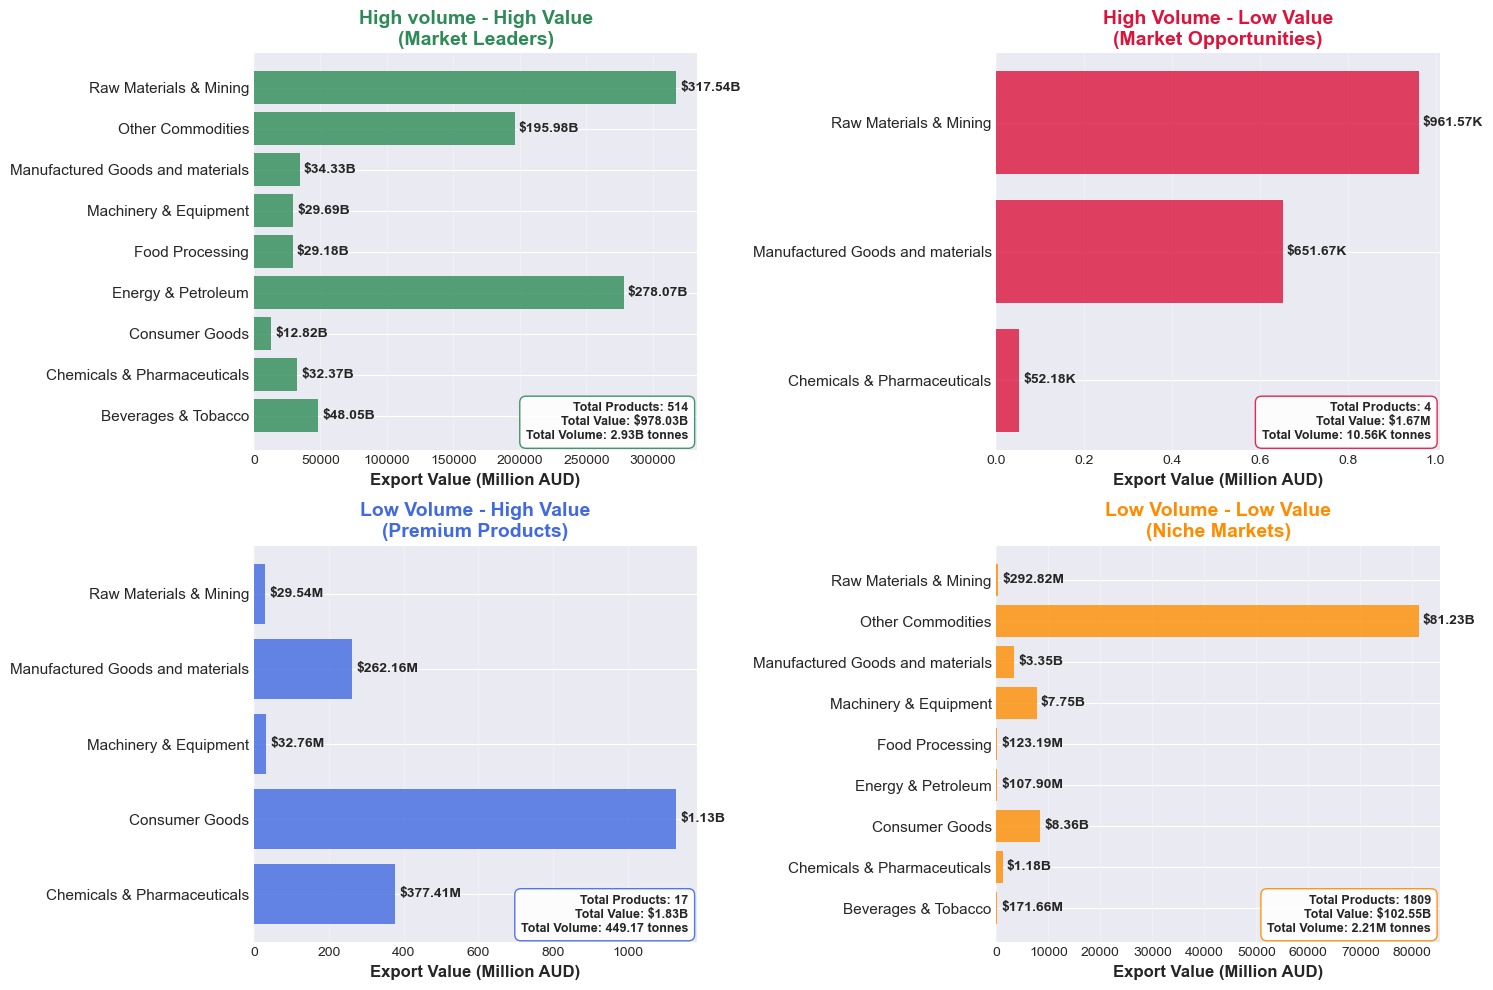


=== VOLUME VS. VALUE INSIGHTS ===
HIGH VOLUME - LOW VALUE OPPORTUNITIES:
   Products: 4
   Total Value: $0.00B
   Total Volume: 0.0M tonnes
   Avg Value per Tonne: $158
   Business Opportunity: Optimize pricing or processing for these high-volume products

 LOW VOLUME - HIGH VALUE PREMIUM PRODUCTS:
   Products: 17
   Total Value: $1.83B
   Total Volume: 0.0M tonnes
   Avg Value per Tonne: $4,074,870
   Business Opportunity: Focus on quality and premium positioning

 HIGH VOLUME - HIGH VALUE MARKET LEADERS:
   Products: 514
   Total Value: $978.03B
   Total Volume: 2928.5M tonnes
   Avg Value per Tonne: $334
   Business Strategy: Maintain market leadership and competitive advantage


In [40]:
# Stakeholder-Friendly Volume vs Value Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Define strategic categories with descriptive titles
categories = {
    'High Volume - High Value': (ax1, '#2E8B57', 'High volume - High Value\n(Market Leaders)'),
    'High Volume - Low Value': (ax2, '#DC143C', 'High Volume - Low Value\n(Market Opportunities)'),
    'Low Volume - High Value': (ax3, '#4169E1', 'Low Volume - High Value\n(Premium Products)'),
    'Low Volume - Low Value': (ax4, '#FF8C00', 'Low Volume - Low Value\n(Niche Markets)')
}

# Create clean, simple charts for each strategic category
for category_name, (ax, color, title) in categories.items():
    # Get products in this category
    category_products = product_analysis[product_analysis['volume_value_category'] == category_name]
    
    if len(category_products) > 0:
        # Group by industry for cleaner visualization
        industry_summary = category_products.groupby('industry_category').agg({
            'value_fob_aud': 'sum',
            'gross_weight_tonnes': 'sum'
        }).round(2)
        
        # Function to format large numbers with proper suffixes
        def format_number(value, unit_type="value"):
            """Format numbers with B, M, K suffixes and appropriate decimal places"""
            if value >= 1e9:
                return f"{value/1e9:.2f}B"
            elif value >= 1e6:
                return f"{value/1e6:.2f}M"
            elif value >= 1e3:
                return f"{value/1e3:.2f}K"
            else:
                return f"{value:.2f}"
        
        # Function to format volume with appropriate units
        def format_volume(value):
            """Format volume values with appropriate units"""
            if value >= 1e9:
                return f"{value/1e9:.2f}B tonnes"
            elif value >= 1e6:
                return f"{value/1e6:.2f}M tonnes"
            elif value >= 1e3:
                return f"{value/1e3:.2f}K tonnes"
            else:
                return f"{value:.2f} tonnes"
        
        # Create horizontal bar chart showing industries
        industries = industry_summary.index
        values = industry_summary['value_fob_aud']
        
        # Create bars with consistent color
        bars = ax.barh(range(len(industries)), values / 1e6, color=color, alpha=0.8)
        
        # Set chart properties
        ax.set_yticks(range(len(industries)))
        ax.set_yticklabels(industries, fontsize=11)
        ax.set_xlabel('Export Value (Million AUD)', fontsize=12, fontweight='bold')
        ax.set_title(f'{title}', fontsize=14, fontweight='bold', color=color)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars with proper formatting
        for i, (bar, value) in enumerate(zip(bars, values)):
            width = bar.get_width()
            formatted_value = format_number(value)
            ax.text(width + max(values)/1e6*0.01, bar.get_y() + bar.get_height()/2,
                   f'${formatted_value}', ha='left', va='center', fontsize=10, fontweight='bold')
        
        # Add summary box with properly formatted values
        total_value = category_products['value_fob_aud'].sum()
        total_volume = category_products['gross_weight_tonnes'].sum()
        product_count = len(category_products)
        
        summary_text = f'Total Products: {product_count}\nTotal Value: ${format_number(total_value)}\nTotal Volume: {format_volume(total_volume)}'
        ax.text(0.98, 0.02, summary_text, transform=ax.transAxes, fontsize=9, fontweight='bold',
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor=color))
    else:
        # No products in this category
        ax.text(0.5, 0.5, f'No products\nin this category', 
                transform=ax.transAxes, fontsize=14, fontweight='bold',
                ha='center', va='center', color='gray',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
        ax.set_title(f'{title}', fontsize=14, fontweight='bold', color=color)
        ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

# Summary insights
print("\n=== VOLUME VS. VALUE INSIGHTS ===")

# High Volume - Low Value opportunities
hv_lv_opportunities = product_analysis[product_analysis['volume_value_category'] == 'High Volume - Low Value']
if len(hv_lv_opportunities) > 0:
    total_hv_lv_value = hv_lv_opportunities['value_fob_aud'].sum()
    total_hv_lv_volume = hv_lv_opportunities['gross_weight_tonnes'].sum()
    print(f"HIGH VOLUME - LOW VALUE OPPORTUNITIES:")
    print(f"   Products: {len(hv_lv_opportunities)}")
    print(f"   Total Value: ${total_hv_lv_value/1e9:.2f}B")
    print(f"   Total Volume: {total_hv_lv_volume/1e6:.1f}M tonnes")
    print(f"   Avg Value per Tonne: ${(total_hv_lv_value/total_hv_lv_volume):,.0f}")
    print(f"   Business Opportunity: Optimize pricing or processing for these high-volume products")

# Low Volume - High Value premium products
lv_hv_premium = product_analysis[product_analysis['volume_value_category'] == 'Low Volume - High Value']
if len(lv_hv_premium) > 0:
    total_lv_hv_value = lv_hv_premium['value_fob_aud'].sum()
    total_lv_hv_volume = lv_hv_premium['gross_weight_tonnes'].sum()
    print(f"\n LOW VOLUME - HIGH VALUE PREMIUM PRODUCTS:")
    print(f"   Products: {len(lv_hv_premium)}")
    print(f"   Total Value: ${total_lv_hv_value/1e9:.2f}B")
    print(f"   Total Volume: {total_lv_hv_volume/1e6:.1f}M tonnes")
    print(f"   Avg Value per Tonne: ${(total_lv_hv_value/total_lv_hv_volume):,.0f}")
    print(f"   Business Opportunity: Focus on quality and premium positioning")

# High Volume - High Value leaders
hv_hv_leaders = product_analysis[product_analysis['volume_value_category'] == 'High Volume - High Value']
if len(hv_hv_leaders) > 0:
    total_hv_hv_value = hv_hv_leaders['value_fob_aud'].sum()
    total_hv_hv_volume = hv_hv_leaders['gross_weight_tonnes'].sum()
    print(f"\n HIGH VOLUME - HIGH VALUE MARKET LEADERS:")
    print(f"   Products: {len(hv_hv_leaders)}")
    print(f"   Total Value: ${total_hv_hv_value/1e9:.2f}B")
    print(f"   Total Volume: {total_hv_hv_volume/1e6:.1f}M tonnes")
    print(f"   Avg Value per Tonne: ${(total_hv_hv_value/total_hv_hv_volume):,.0f}")
    print(f"   Business Strategy: Maintain market leadership and competitive advantage")





##### High Volume – High Value (Market Leaders)

###### These industries send out a lot of goods (high volume) and also make a lot of money (high value).They are Australia’s strongest and most important export sectors.Because they move huge amounts of products and earn very high revenue, they play a major role in the country’s economy. Even a small improvement in these industries—like faster shipping, better port operations, or smoother supply chains—can add millions or even billions of dollars to Australia’s export earnings.

###### In simple terms, this group contains the big, reliable, money-making industries that Australia depends on.

##### Low Volume – High Value (Premium Products)

###### These industries export only a small amount of goods (low volume), but each shipment is worth a lot of money (high value). They are usually special, high-quality, or advanced products where value is more important than quantity.Even though they don’t ship much, they still earn a lot because every tonne or shipment is very valuable. These industries are great opportunities for growth because they don’t need massive shipping capacity but still bring in strong profits.

###### In simple terms, this group contains premium, high-profit products that give Australia big returns even from small shipments.

In [41]:
# PRODUCT-MARKET ANALYSIS: "What are we exporting to whom?"
print("=== PRODUCT-MARKET ANALYSIS ===")
print("Goal: Identify how each product performs across destination countries")
print("=" * 60)

# Function to format large numbers with proper suffixes
def format_number(value):
    """Format numbers with B, M, K suffixes and appropriate decimal places"""
    if value >= 1e9:
        return f"{value/1e9:.2f}B"
    elif value >= 1e6:
        return f"{value/1e6:.2f}M"
    elif value >= 1e3:
        return f"{value/1e3:.2f}K"
    else:
        return f"{value:.2f}"

# 1. TOP PRODUCTS BY EXPORT VALUE
print("\n TOP 10 EXPORT PRODUCTS BY VALUE:")
top_products = df.groupby('product_description').agg({
    'value_fob_aud': 'sum',
    'gross_weight_tonnes': 'sum',
    'country_of_destination': 'nunique'
}).round(2)

top_products.columns = ['Total_Value', 'Total_Weight', 'Countries_Served']
top_products = top_products.sort_values('Total_Value', ascending=False).head(10)

for i, (product, row) in enumerate(top_products.iterrows(), 1):
    print(f"{i}. {product[:60]}...")
    print(f"   Export Value: ${format_number(row['Total_Value'])}")
    print(f"   Weight: {format_number(row['Total_Weight'])} tonnes")
    print(f"   Countries Served: {row['Countries_Served']}")
    print()

# 2. TOP DESTINATION COUNTRIES
print("\n TOP 15 DESTINATION COUNTRIES:")
top_countries = df.groupby('country_of_destination').agg({
    'value_fob_aud': 'sum',
    'gross_weight_tonnes': 'sum',
    'product_description': 'nunique'
}).round(2)

top_countries.columns = ['Total_Value', 'Total_Weight', 'Products_Imported']
top_countries = top_countries.sort_values('Total_Value', ascending=False).head(15)

for i, (country, row) in enumerate(top_countries.iterrows(), 1):
    print(f"{i}. {country}")
    print(f"   Import Value: ${format_number(row['Total_Value'])}")
    print(f"   Weight: {format_number(row['Total_Weight'])} tonnes")
    print(f"   Products Imported: {row['Products_Imported']}")
    print()

# 3. PRODUCT-COUNTRY MATRIX (Top combinations)
print("\n TOP PRODUCT-COUNTRY COMBINATIONS:")
product_country_matrix = df.groupby(['product_description', 'country_of_destination']).agg({
    'value_fob_aud': 'sum',
    'gross_weight_tonnes': 'sum'
}).round(2)

product_country_matrix.columns = ['Value', 'Weight']
top_combinations = product_country_matrix.sort_values('Value', ascending=False).head(15)

for i, ((product, country), row) in enumerate(top_combinations.iterrows(), 1):
    print(f"{i}. {product[:40]}... → {country}")
    print(f"   Export Value: ${format_number(row['Value'])}")
    print(f"   Weight: {format_number(row['Weight'])} tonnes")
    print()


=== PRODUCT-MARKET ANALYSIS ===
Goal: Identify how each product performs across destination countries

 TOP 10 EXPORT PRODUCTS BY VALUE:
1. Iron ore and concentrates, not agglomerated...
   Export Value: $212.24B
   Weight: 1.65B tonnes
   Countries Served: 21.0

2. Special transactions and commodities not classified accordin...
   Export Value: $144.82B
   Weight: 206.73M tonnes
   Countries Served: 170.0

3. Bituminous coal, whether or not pulverized, not agglomerated...
   Export Value: $132.12B
   Weight: 621.83M tonnes
   Countries Served: 41.0

4. Natural gas, liquefied...
   Export Value: $112.93B
   Weight: 139.36M tonnes
   Countries Served: 1.0

5. Non-monetary gold (incl. gold plated with platinum) unwrough...
   Export Value: $78.71B
   Weight: 680.77 tonnes
   Countries Served: 44.0

6. Commodities and transactions not classified elsewhere in the...
   Export Value: $47.20B
   Weight: 1.91M tonnes
   Countries Served: 130.0

7. Metalliferous ores and metal scrap...
   Expo

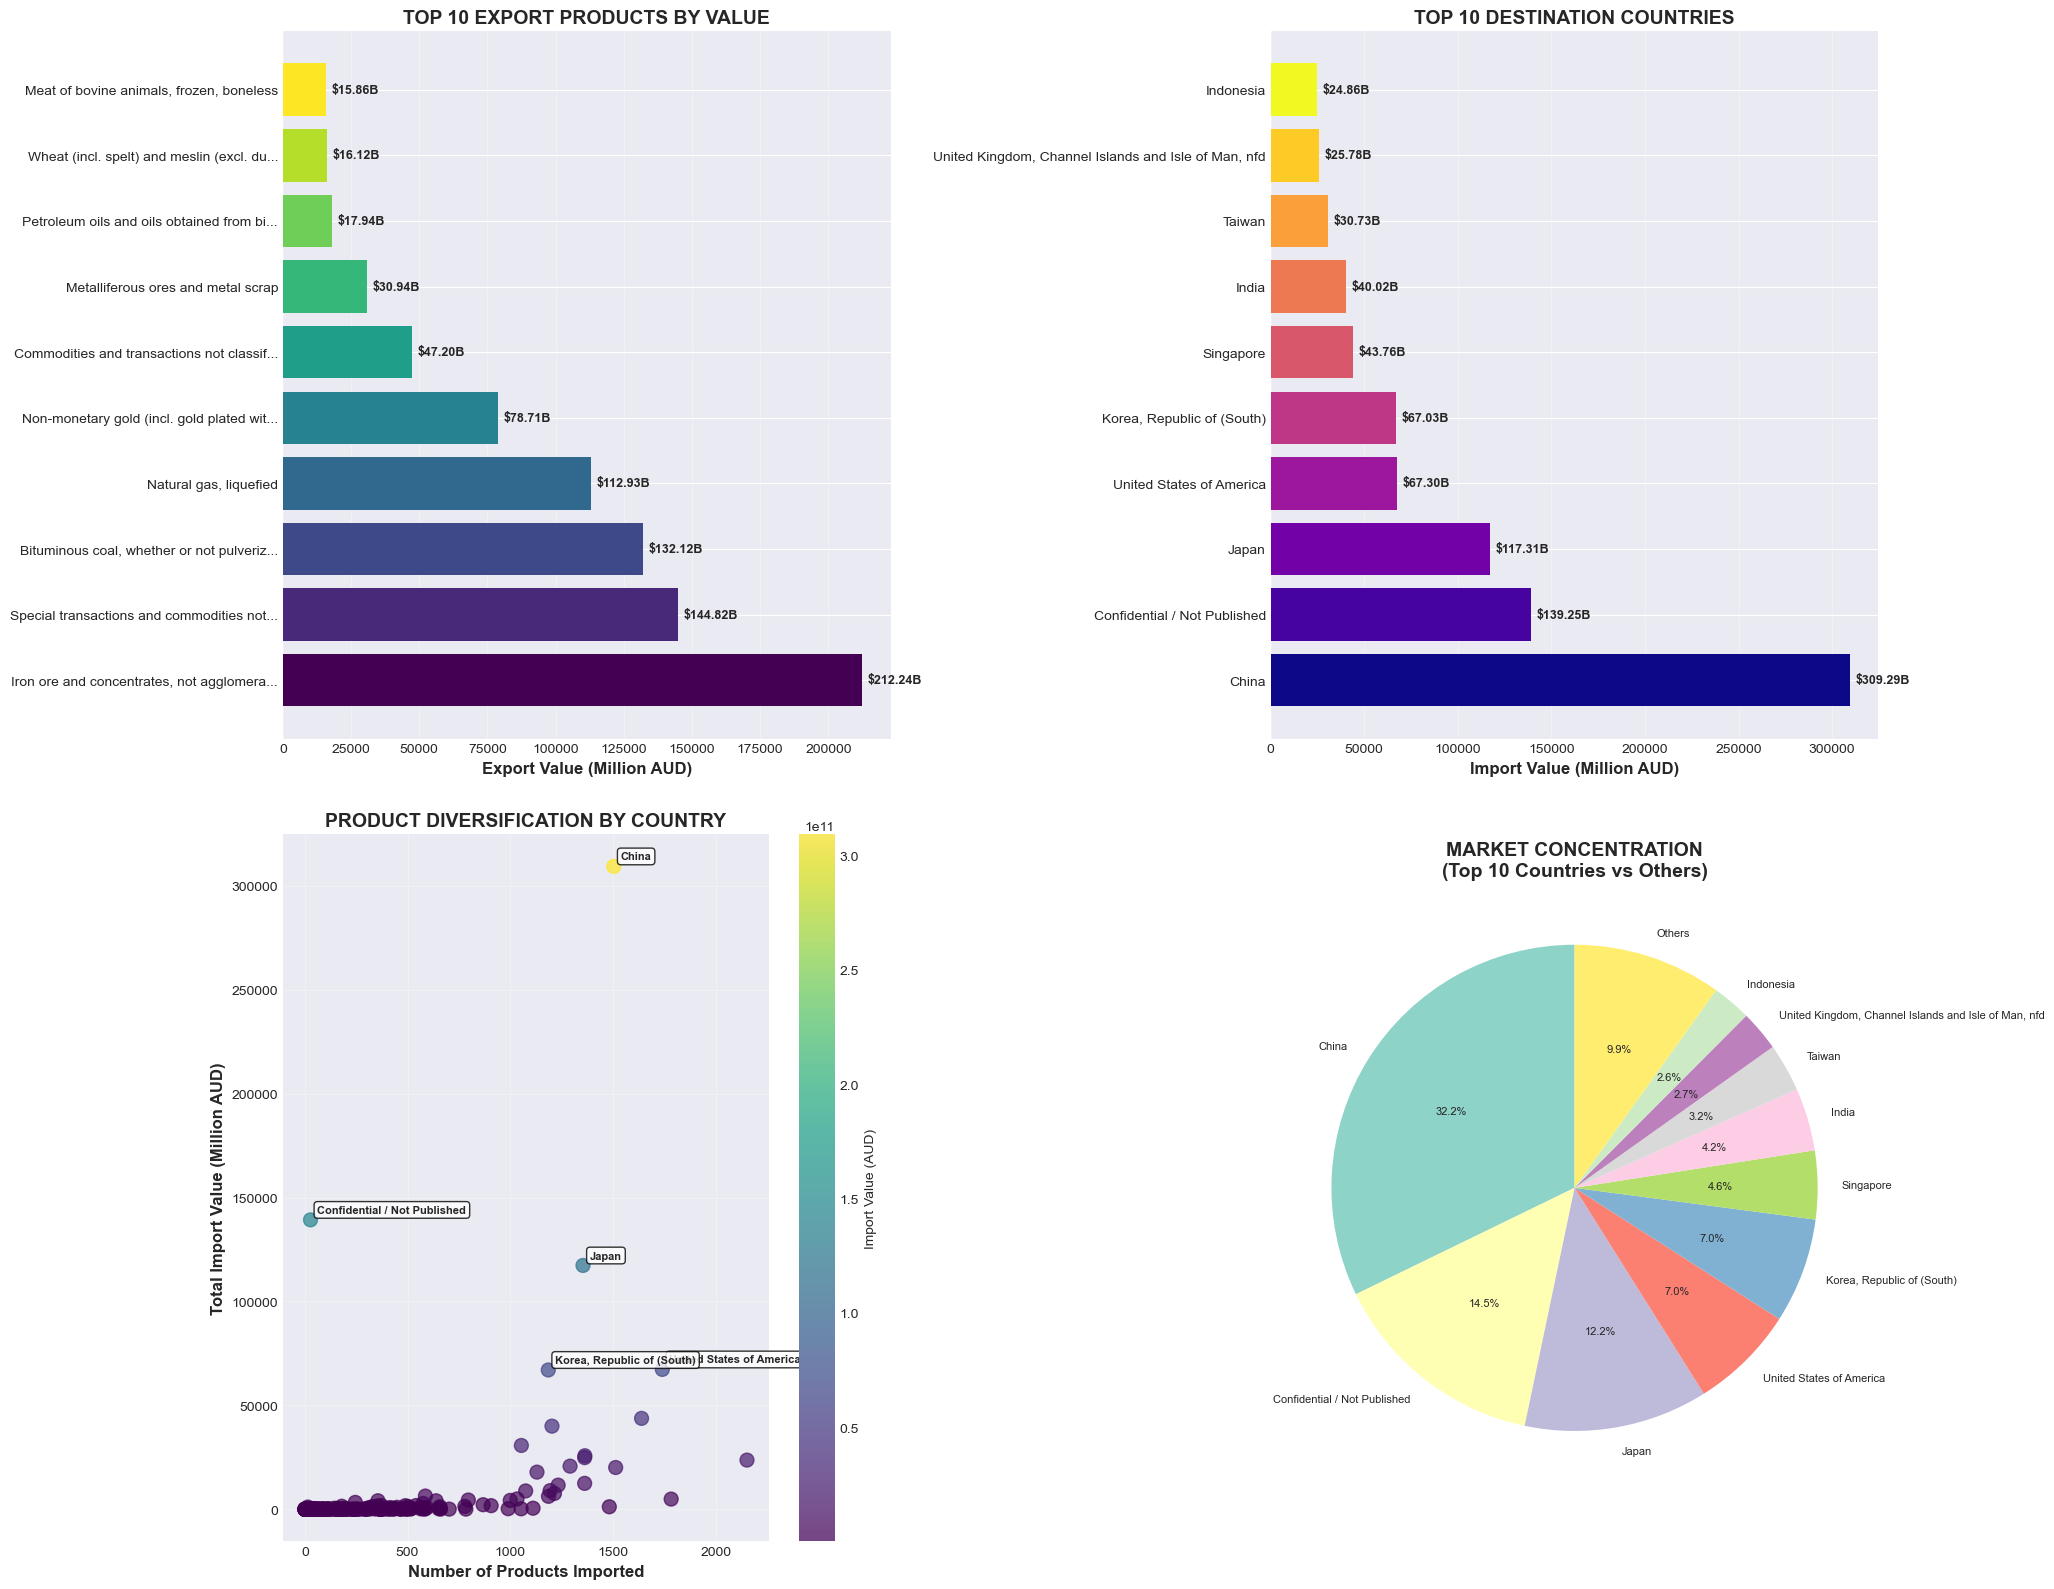


 PRODUCT-MARKET ANALYSIS SUMMARY:
 Top Export Product: Iron ore and concentrates, not agglomerated
 Export Value: $212.24B
 Countries Served: 21.0
Top Destination Country: China
 Import Value: $309.29B
 Products Imported: 1504.0

 Market Concentration:
   Top 5 countries: 72.9% of total exports
   Top 10 countries: 90.1% of total exports

 Key Insights:
   • Iron ore and concentrates, not agglomerated... is Australia's most valuable export
   • China is Australia's largest export market
   • Market is highly concentrated in top destinations
   • Diversification opportunity: 220 countries served


In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. TOP PRODUCTS BY EXPORT VALUE (Horizontal Bar Chart)
top_10_products = top_products.head(10)
bars1 = ax1.barh(range(len(top_10_products)), top_10_products['Total_Value'] / 1e6, 
                 color=plt.cm.viridis(np.linspace(0, 1, len(top_10_products))))

ax1.set_yticks(range(len(top_10_products)))
ax1.set_yticklabels([prod[:40] + '...' if len(prod) > 40 else prod for prod in top_10_products.index], fontsize=10)
ax1.set_xlabel('Export Value (Million AUD)', fontsize=12, fontweight='bold')
ax1.set_title('TOP 10 EXPORT PRODUCTS BY VALUE', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, top_10_products['Total_Value'])):
    width = bar.get_width()
    ax1.text(width + max(top_10_products['Total_Value'])/1e6*0.01, bar.get_y() + bar.get_height()/2,
             f'${format_number(value)}', ha='left', va='center', fontsize=9, fontweight='bold')

# 2. TOP DESTINATION COUNTRIES (Horizontal Bar Chart)
top_10_countries = top_countries.head(10)
bars2 = ax2.barh(range(len(top_10_countries)), top_10_countries['Total_Value'] / 1e6,
                 color=plt.cm.plasma(np.linspace(0, 1, len(top_10_countries))))

ax2.set_yticks(range(len(top_10_countries)))
ax2.set_yticklabels(top_10_countries.index, fontsize=10)
ax2.set_xlabel('Import Value (Million AUD)', fontsize=12, fontweight='bold')
ax2.set_title('TOP 10 DESTINATION COUNTRIES', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, top_10_countries['Total_Value'])):
    width = bar.get_width()
    ax2.text(width + max(top_10_countries['Total_Value'])/1e6*0.01, bar.get_y() + bar.get_height()/2,
             f'${format_number(value)}', ha='left', va='center', fontsize=9, fontweight='bold')

# 3. PRODUCT DIVERSIFICATION BY COUNTRY (Scatter Plot)
country_product_diversity = df.groupby('country_of_destination').agg({
    'value_fob_aud': 'sum',
    'product_description': 'nunique'
}).round(2)

scatter = ax3.scatter(country_product_diversity['product_description'], 
                      country_product_diversity['value_fob_aud'] / 1e6,
                      c=country_product_diversity['value_fob_aud'], 
                      cmap='viridis', s=100, alpha=0.7)

ax3.set_xlabel('Number of Products Imported', fontsize=12, fontweight='bold')
ax3.set_ylabel('Total Import Value (Million AUD)', fontsize=12, fontweight='bold')
ax3.set_title('PRODUCT DIVERSIFICATION BY COUNTRY', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Import Value (AUD)', fontsize=10)

# Highlight top countries
top_5_countries_names = top_countries.head(5).index
for country in top_5_countries_names:
    if country in country_product_diversity.index:
        x = country_product_diversity.loc[country, 'product_description']
        y = country_product_diversity.loc[country, 'value_fob_aud'] / 1e6
        ax3.annotate(country, (x, y), xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 4. MARKET CONCENTRATION ANALYSIS (Pie Chart)
# Top 10 countries market share
top_10_share = top_countries.head(10)['Total_Value']
others_share = top_countries.iloc[10:]['Total_Value'].sum()
market_share_data = list(top_10_share.values) + [others_share]
market_share_labels = list(top_10_share.index) + ['Others']

colors = plt.cm.Set3(np.linspace(0, 1, len(market_share_data)))
wedges, texts, autotexts = ax4.pie(market_share_data, labels=market_share_labels,
                                   autopct='%1.1f%%', colors=colors, startangle=90,
                                   textprops={'fontsize': 8})

ax4.set_title('MARKET CONCENTRATION\n(Top 10 Countries vs Others)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n PRODUCT-MARKET ANALYSIS SUMMARY:")
print(f" Top Export Product: {top_products.index[0]}")
print(f" Export Value: ${format_number(top_products.iloc[0]['Total_Value'])}")
print(f" Countries Served: {top_products.iloc[0]['Countries_Served']}")

print(f"Top Destination Country: {top_countries.index[0]}")
print(f" Import Value: ${format_number(top_countries.iloc[0]['Total_Value'])}")
print(f" Products Imported: {top_countries.iloc[0]['Products_Imported']}")

print(f"\n Market Concentration:")
top_5_share = top_countries.head(5)['Total_Value'].sum() / top_countries['Total_Value'].sum() * 100
top_10_share_pct = top_countries.head(10)['Total_Value'].sum() / top_countries['Total_Value'].sum() * 100
print(f"   Top 5 countries: {top_5_share:.1f}% of total exports")
print(f"   Top 10 countries: {top_10_share_pct:.1f}% of total exports")

print(f"\n Key Insights:")
print(f"   • {top_products.index[0][:50]}... is Australia's most valuable export")
print(f"   • {top_countries.index[0]} is Australia's largest export market")
print(f"   • Market is {('highly' if top_5_share > 50 else 'moderately')} concentrated in top destinations")
print(f"   • Diversification opportunity: {len(df['country_of_destination'].unique())} countries served")

#### Top 10 Export Products by Value

###### This chart highlights Australia’s most valuable export products. Iron ore and concentrates lead overwhelmingly with $212.2 billion AUD, followed by special transactions and commodities ($144.8 B) and bituminous coal ($132.1 B). Other major exports include liquefied natural gas (LNG) ($112.9 B) and non-monetary gold ($78.7 B). These top products reflect Australia’s strong global position in mineral resources and energy exports, which together dominate the country’s trade performance.

###### The export structure shows a heavy reliance on raw commodities, particularly minerals and energy. While these industries drive national revenue, diversifying into value-added and manufacturing exports could strengthen economic resilience and reduce exposure to commodity price fluctuations

#### Top 10 Destination Countries
###### This chart shows where Australia’s exports are going. China remains the dominant trading partner, accounting for roughly $309 billion AUD, far ahead of other destinations such as Japan ($117 B), the United States ($67 B), and South Korea ($67 B). Regional partners like Singapore, India, and Indonesia also feature strongly, reflecting Asia’s importance to Australia’s trade network.

###### Australia’s export economy is closely tied to Asian markets, particularly China, which presents both opportunities and vulnerabilities. Maintaining stable relations and expanding into other high-growth markets like India and Southeast Asia will be key to long-term trade security.

#### Combined  Summary

###### Australia’s export market shows strong value but high concentration risk. China is Australia’s most valuable and most diversified trading partner, importing the widest range of products and generating 32% of total export value. Japan, the United States, and South Korea are also key markets, though with more specialized product demand. Meanwhile, most other countries import a smaller number of products, indicating clear opportunities for trade expansion. Overall, export value is heavily concentrated in the top 10 countries, which together account for over 90% of total trade  highlighting a strategic need to diversify into emerging regions to ensure long-term stability.

##### This code calculates how exports from Australia to each destination country have grown or declined from 2024 to 2025 that’s called Year-over-Year (YoY) Growth.

=== TOP 15 PORTS BY TONNAGE ===

 TOP 15 PORTS BY TONNAGE:
--------------------------------------------------------------------------------
Rank Port Name                                          Tonnage (M tonnes)
--------------------------------------------------------------------------------
1    Port Hedland                                       994.2             
2    Port Walcott                                       300.5             
3    Dampier (King Bay)                                 298.1             
4    Newcastle                                          264.2             
5    Conf Aust Ports                                    206.5             
6    Hay Point                                          169.6             
7    Gladstone                                          162.4             
8    Abbot Point                                        61.2              
9    Weipa                                              53.0              
10   Offshore Ports - Western

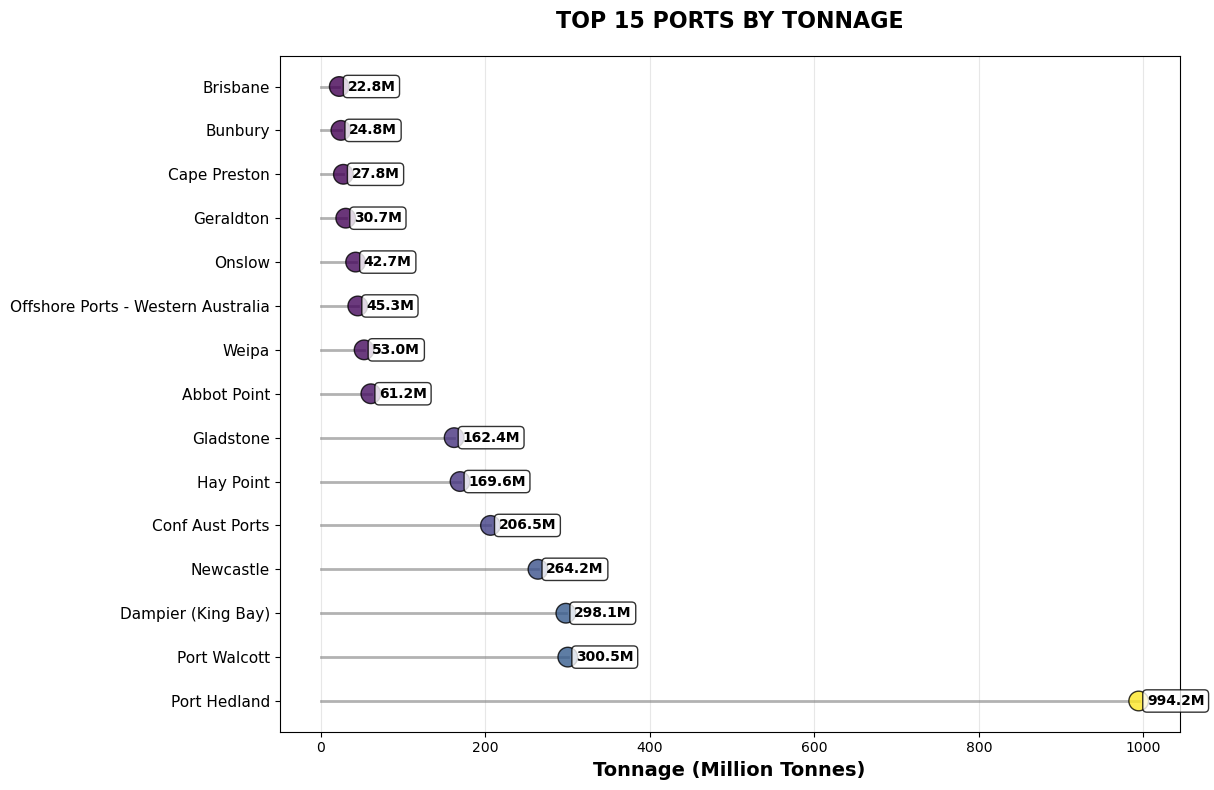

In [44]:




# TOP 15 PORTS - LOLLIPOP CHART VERSION
print("=== TOP 15 PORTS BY TONNAGE ===")

# Group by port of loading and calculate total tonnage
port_tonnage = df.groupby('port_of_loading')['gross_weight_tonnes'].sum().reset_index()
port_tonnage = port_tonnage.sort_values('gross_weight_tonnes', ascending=False)
port_tonnage['tonnage_millions'] = port_tonnage['gross_weight_tonnes'] / 1e6
top_15_ports = port_tonnage.head(15)

# Display the data first
print(f"\n TOP 15 PORTS BY TONNAGE:")
print("-" * 80)
print(f"{'Rank':<4} {'Port Name':<50} {'Tonnage (M tonnes)':<18}")
print("-" * 80)

for i, (_, row) in enumerate(top_15_ports.iterrows(), 1):
    port_name = row['port_of_loading']
    print(f"{i:<4} {port_name:<50} {row['tonnage_millions']:<18.1f}")

print(f"\n SUMMARY:")
print(f"   Total ports analyzed: {len(port_tonnage)}")
print(f"   Total tonnage: {port_tonnage['gross_weight_tonnes'].sum()/1e6:.1f}M tonnes")



# Use a large figure size
plt.figure(figsize=(12, 8))

# First, draw the horizontal lines (the "sticks")
for i, (_, row) in enumerate(top_15_ports.iterrows()):
    plt.plot([0, row['tonnage_millions']], [i, i], color='gray', alpha=0.6, linewidth=2)

# Then, add the dots (the "lollipops") at the end of each line
scatter = plt.scatter(top_15_ports['tonnage_millions'], range(len(top_15_ports)), 
                     c=top_15_ports['tonnage_millions'], cmap='viridis', s=200, alpha=0.8, 
                     edgecolors='black', linewidth=1, zorder=3)

# Set up the chart
plt.yticks(range(len(top_15_ports)), 
           [port for port in top_15_ports['port_of_loading']],
           fontsize=11)

plt.xlabel('Tonnage (Million Tonnes)', fontsize=14, fontweight='bold')
plt.title('TOP 15 PORTS BY TONNAGE', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels on the dots
for i, (_, row) in enumerate(top_15_ports.iterrows()):
    plt.text(row['tonnage_millions'] + 10, i, f'{row["tonnage_millions"]:.1f}M', 
             ha='left', va='center', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Clean layout
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.95)

plt.show()


###### Top 15 Ports by Tonnage (2024–2025)

###### This chart shows the ports that handle the highest export volumes across Australia. Port Hedland stands out as the country’s busiest export hub, managing about 946 million tonnes, far exceeding all other ports. It is followed by Dampier (King Bay) and Port Walcott, each handling around 283 million tonnes, while Newcastle, Gladstone, and Hay Point also manage significant volumes. Most of these top ports are located in Western Australia and Queensland, reflecting the dominance of bulk commodity exports such as iron ore, coal, and liquefied natural gas (LNG).

In [45]:
# AVERAGE VALUE PER SHIPMENT PER PORT - OPERATIONAL EFFICIENCY ANALYSIS
print("=== AVERAGE VALUE PER SHIPMENT PER PORT - OPERATIONAL EFFICIENCY ===")

# Calculate port metrics focusing on shipment value efficiency
port_efficiency = df.groupby('port_of_loading').agg({
    'value_fob_aud': 'sum',
    'country_of_destination': 'count'  # Count of shipments/records
}).reset_index()

port_efficiency = port_efficiency.rename(columns={'country_of_destination': 'shipment_count'})

# Calculate key efficiency metrics
port_efficiency['avg_value_per_shipment'] = port_efficiency['value_fob_aud'] / port_efficiency['shipment_count']
port_efficiency['total_value_millions'] = port_efficiency['value_fob_aud'] / 1e6
port_efficiency['shipments_per_day'] = port_efficiency['shipment_count'] / 730  # 2 years of data

# Filter for ports with significant activity (at least 50 shipments)
significant_ports = port_efficiency[port_efficiency['shipment_count'] >= 50].copy()
significant_ports = significant_ports.sort_values('avg_value_per_shipment', ascending=False)

print(f" ANALYSIS SCOPE:")
print(f"   Total ports analyzed: {len(port_efficiency)}")
print(f"   Significant ports (≥50 shipments): {len(significant_ports)}")
print(f"   Total shipments: {port_efficiency['shipment_count'].sum():,}")
print(f"   Total export value: ${port_efficiency['value_fob_aud'].sum()/1e9:.1f}B")

# Calculate industry benchmarks
avg_value_per_shipment = significant_ports['avg_value_per_shipment'].mean()
avg_shipments_per_day = significant_ports['shipments_per_day'].mean()

print(f"\nINDUSTRY BENCHMARKS:")
print(f"   Average value per shipment: ${avg_value_per_shipment:,.0f}")
print(f"   Average shipments per day: {avg_shipments_per_day:.1f}")

# 1. HIGH-VALUE OPERATIONS (Premium Ports)
print(f"\nHIGH-VALUE OPERATIONS (Premium Ports):")
print("=" * 90)
print("These ports handle high-value cargo with efficient operations")
print("-" * 90)
print(f"{'Rank':<4} {'Port Name':<35} {'Avg Value/Shipment':<18} {'Total Shipments':<15} {'Shipments/Day':<15}")
print("-" * 90)

high_value_ports = significant_ports.head(15)
for i, (_, row) in enumerate(high_value_ports.iterrows(), 1):
    port_name = row['port_of_loading'][:32] + '...' if len(row['port_of_loading']) > 35 else row['port_of_loading']
    print(f"{i:<4} {port_name:<35} ${row['avg_value_per_shipment']:<17,.0f} {row['shipment_count']:<14,} {row['shipments_per_day']:<14.1f}")

# 2. POTENTIAL CONGESTION INDICATORS (High Volume, Low Value)
print(f"\n POTENTIAL CONGESTION INDICATORS:")
print("=" * 90)
print("These ports have high shipment volume but low value per shipment")
print("→ Possible congestion from many small shipments or bulk commodities")
print("-" * 90)
print(f"{'Rank':<4} {'Port Name':<35} {'Avg Value/Shipment':<18} {'Total Shipments':<15} {'Shipments/Day':<15}")
print("-" * 90)

# Identify ports with high shipment volume but low value per shipment
congestion_risk = significant_ports.copy()
congestion_risk['congestion_score'] = (congestion_risk['shipments_per_day'] / congestion_risk['shipments_per_day'].max()) - (congestion_risk['avg_value_per_shipment'] / congestion_risk['avg_value_per_shipment'].max())

high_congestion_risk = congestion_risk.nlargest(15, 'congestion_score')
for i, (_, row) in enumerate(high_congestion_risk.iterrows(), 1):
    port_name = row['port_of_loading'][:32] + '...' if len(row['port_of_loading']) > 35 else row['port_of_loading']
    print(f"{i:<4} {port_name:<35} ${row['avg_value_per_shipment']:<17,.0f} {row['shipment_count']:<14,} {row['shipments_per_day']:<14.1f}")

# 3. EFFICIENCY CATEGORIZATION
print(f"\nPORT EFFICIENCY CATEGORIZATION:")
print("=" * 80)

# Define efficiency thresholds
high_value_threshold = significant_ports['avg_value_per_shipment'].quantile(0.75)
high_volume_threshold = significant_ports['shipments_per_day'].quantile(0.75)

# Categorize ports
significant_ports['efficiency_category'] = 'Standard'
significant_ports.loc[
    (significant_ports['avg_value_per_shipment'] >= high_value_threshold) & 
    (significant_ports['shipments_per_day'] >= high_volume_threshold), 'efficiency_category'
] = 'High Efficiency (High Value + High Volume)'
significant_ports.loc[
    (significant_ports['avg_value_per_shipment'] >= high_value_threshold) & 
    (significant_ports['shipments_per_day'] < high_volume_threshold), 'efficiency_category'
] = 'Premium Operations (High Value, Low Volume)'
significant_ports.loc[
    (significant_ports['avg_value_per_shipment'] < high_value_threshold) & 
    (significant_ports['shipments_per_day'] >= high_volume_threshold), 'efficiency_category'
] = 'Bulk Operations (Low Value, High Volume)'

# Count ports in each category
efficiency_counts = significant_ports['efficiency_category'].value_counts()
print("Port Distribution by Efficiency Category:")
for category, count in efficiency_counts.items():
    print(f"   {category}: {count} ports")

# 4. KEY INSIGHTS
print(f"\nKEY OPERATIONAL INSIGHTS:")
print("=" * 80)

print(f" TOP PERFORMERS:")
high_efficiency = efficiency_counts.get('High Efficiency (High Value + High Volume)', 0)
premium_ops = efficiency_counts.get('Premium Operations (High Value, Low Volume)', 0)
print(f"   High Efficiency Ports: {high_efficiency} (handle both high value and high volume)")
print(f"   Premium Operations: {premium_ops} (specialized high-value cargo)")

print(f"\n ATTENTION NEEDED:")
bulk_ops = efficiency_counts.get('Bulk Operations (Low Value, High Volume)', 0)
print(f"   Bulk Operations: {bulk_ops} (high volume but low value - potential congestion)")

print(f"\nEFFICIENCY METRICS:")
print(f"   Average value per shipment: ${significant_ports['avg_value_per_shipment'].mean():,.0f}")
print(f"   Highest value per shipment: ${significant_ports['avg_value_per_shipment'].max():,.0f}")
print(f"   Lowest value per shipment: ${significant_ports['avg_value_per_shipment'].min():,.0f}")

print("Average Value per Shipment Analysis completed!")


=== AVERAGE VALUE PER SHIPMENT PER PORT - OPERATIONAL EFFICIENCY ===
 ANALYSIS SCOPE:
   Total ports analyzed: 74
   Significant ports (≥50 shipments): 48
   Total shipments: 1,557,704
   Total export value: $1082.4B

INDUSTRY BENCHMARKS:
   Average value per shipment: $17,952,667
   Average shipments per day: 44.4

HIGH-VALUE OPERATIONS (Premium Ports):
These ports handle high-value cargo with efficient operations
------------------------------------------------------------------------------------------
Rank Port Name                           Avg Value/Shipment Total Shipments Shipments/Day  
------------------------------------------------------------------------------------------
1    Port Walcott                        $101,753,232       385            0.5           
2    Port Hedland                        $99,573,705        1,311          1.8           
3    Offshore Ports - Western Australia  $84,228,463        424            0.6           
4    Onslow                          

#### Port Value Visualizations

=== CLEAN AVERAGE VALUE PER SHIPMENT VISUALIZATIONS ===
Creating Top 15 High-Value Ports Chart...
 Creating Lowest 15 Value Ports Chart...


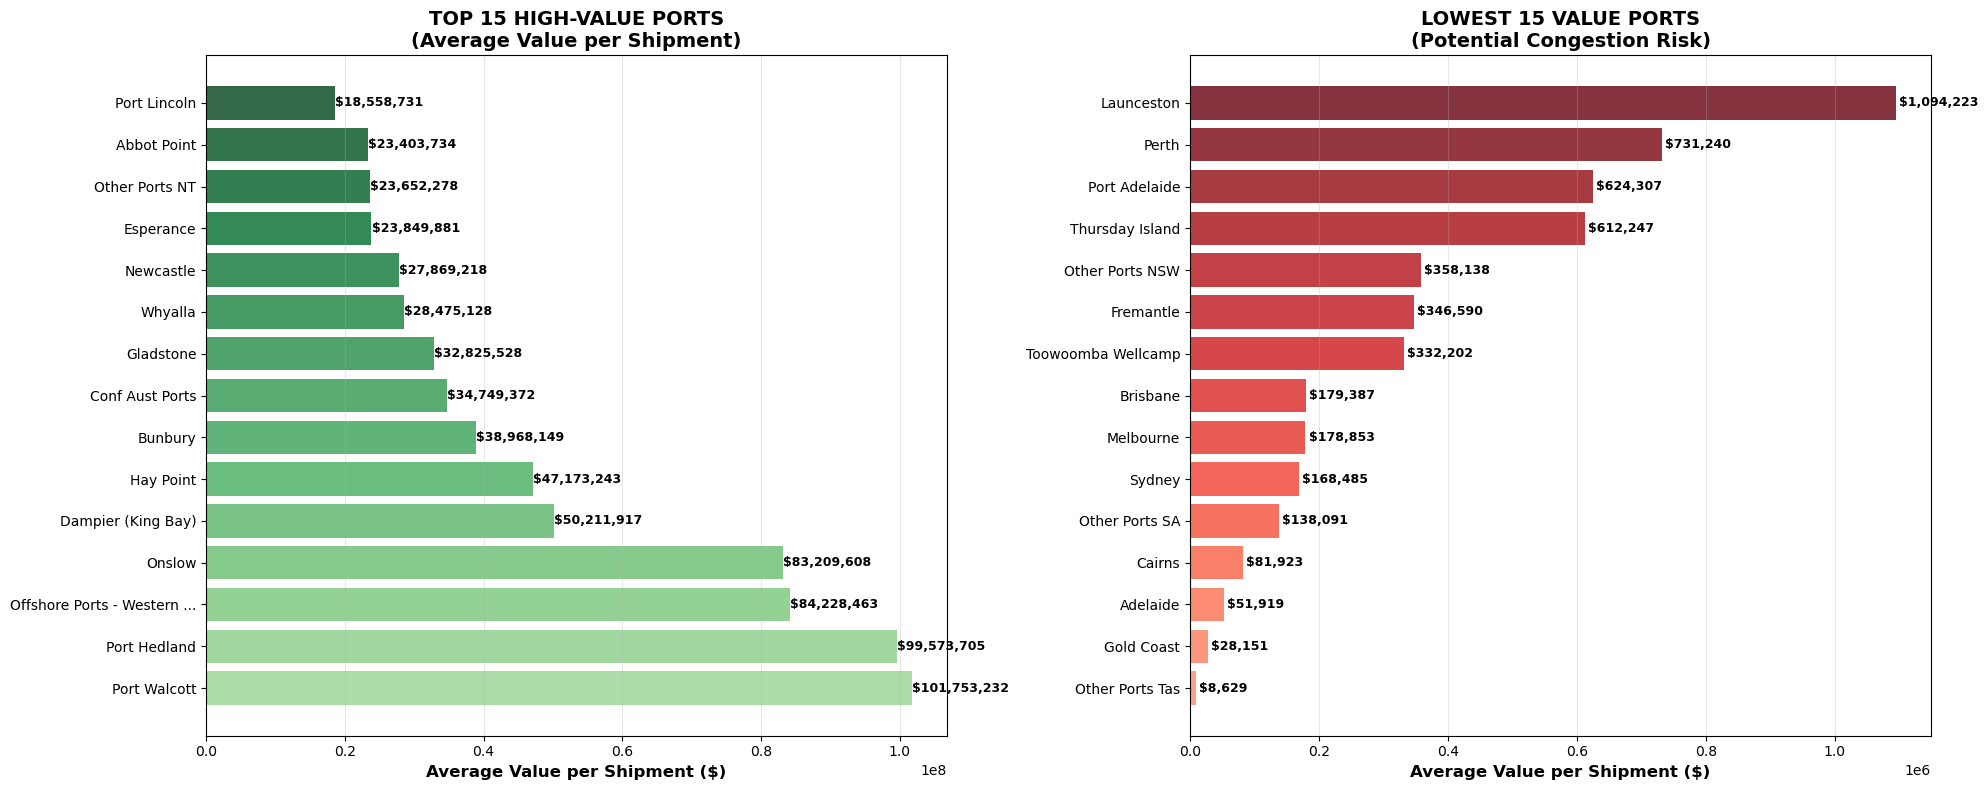

In [46]:
# CLEAN AVERAGE VALUE PER SHIPMENT VISUALIZATIONS - 2 CHARTS ONLY
print("=== CLEAN AVERAGE VALUE PER SHIPMENT VISUALIZATIONS ===")

# Create ONLY 2 visualizations as requested
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 1. TOP 15 HIGH-VALUE PORTS
print("Creating Top 15 High-Value Ports Chart...")

top_15_high_value = significant_ports.head(15)
bars1 = ax1.barh(range(len(top_15_high_value)), top_15_high_value['avg_value_per_shipment'], 
                 color=plt.cm.Greens(np.linspace(0.4, 1, len(top_15_high_value))), alpha=0.8)

ax1.set_yticks(range(len(top_15_high_value)))
ax1.set_yticklabels([port[:25] + '...' if len(port) > 28 else port for port in top_15_high_value['port_of_loading']], fontsize=10)
ax1.set_xlabel('Average Value per Shipment ($)', fontsize=12, fontweight='bold')
ax1.set_title('TOP 15 HIGH-VALUE PORTS\n(Average Value per Shipment)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, top_15_high_value['avg_value_per_shipment'])):
    width = bar.get_width()
    ax1.text(width + 10000, bar.get_y() + bar.get_height()/2,
             f'${value:,.0f}', ha='left', va='center', fontsize=9, fontweight='bold')

# 2. LOWEST 15 VALUE PORTS (Potential Congestion)
print(" Creating Lowest 15 Value Ports Chart...")

lowest_15_value = significant_ports.nsmallest(15, 'avg_value_per_shipment')
bars2 = ax2.barh(range(len(lowest_15_value)), lowest_15_value['avg_value_per_shipment'], 
                 color=plt.cm.Reds(np.linspace(0.4, 1, len(lowest_15_value))), alpha=0.8)

ax2.set_yticks(range(len(lowest_15_value)))
ax2.set_yticklabels([port[:25] + '...' if len(port) > 28 else port for port in lowest_15_value['port_of_loading']], fontsize=10)
ax2.set_xlabel('Average Value per Shipment ($)', fontsize=12, fontweight='bold')
ax2.set_title('LOWEST 15 VALUE PORTS\n(Potential Congestion Risk)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, lowest_15_value['avg_value_per_shipment'])):
    width = bar.get_width()
    ax2.text(width + 5000, bar.get_y() + bar.get_height()/2,
             f'${value:,.0f}', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()




Top 15 High-Value Ports (Average Value per Shipment)

###### This chart shows which Australian ports handle shipments with the highest average value per shipment — a measure of how valuable each export load is. Port Walcott, Port Hedland, and Offshore Ports – Western Australia lead with shipment values between $87M–$100M, reflecting their role in exporting high-value bulk commodities such as iron ore and natural gas. Other ports like Onslow, Dampier (King Bay), and Hay Point also show strong export values, indicating efficient handling of premium or large-scale goods.

Lowest 15 Value Ports (Potential Congestion Risk)

###### This chart highlights ports with the lowest average value per shipment, suggesting they handle many low-value or small-scale exports. Ports such as Launceston, Perth, and Port Adelaide show low average shipment values, typically under $1 million per shipment. These ports may be serving smaller exporters or handling domestic-oriented goods rather than high-value global exports.

#### Regional Analysis

=== EXPORT SHARE BY REGION ANALYSIS ===

Countries mapped to 'Other' (7 countries):
   • Antarctica, nfd
   • Australia (Re-imports)
   • Confidential / Not Published
   • International Waters
   • Ship and Aircraft Stores
   • Unknown
   • Unknown Country

Combined 2 small regions with 'Other' category
Small regions combined: South America, Central America & Caribbean

REGIONAL EXPORT SHARE:
1. Asia-Pacific                69.7% ($ 754.1B)
2. Other                       14.0% ($ 151.2B)
3. North America                6.9% ($  75.0B)
4. Europe                       6.2% ($  67.2B)
5. Middle East & Africa         3.2% ($  35.0B)


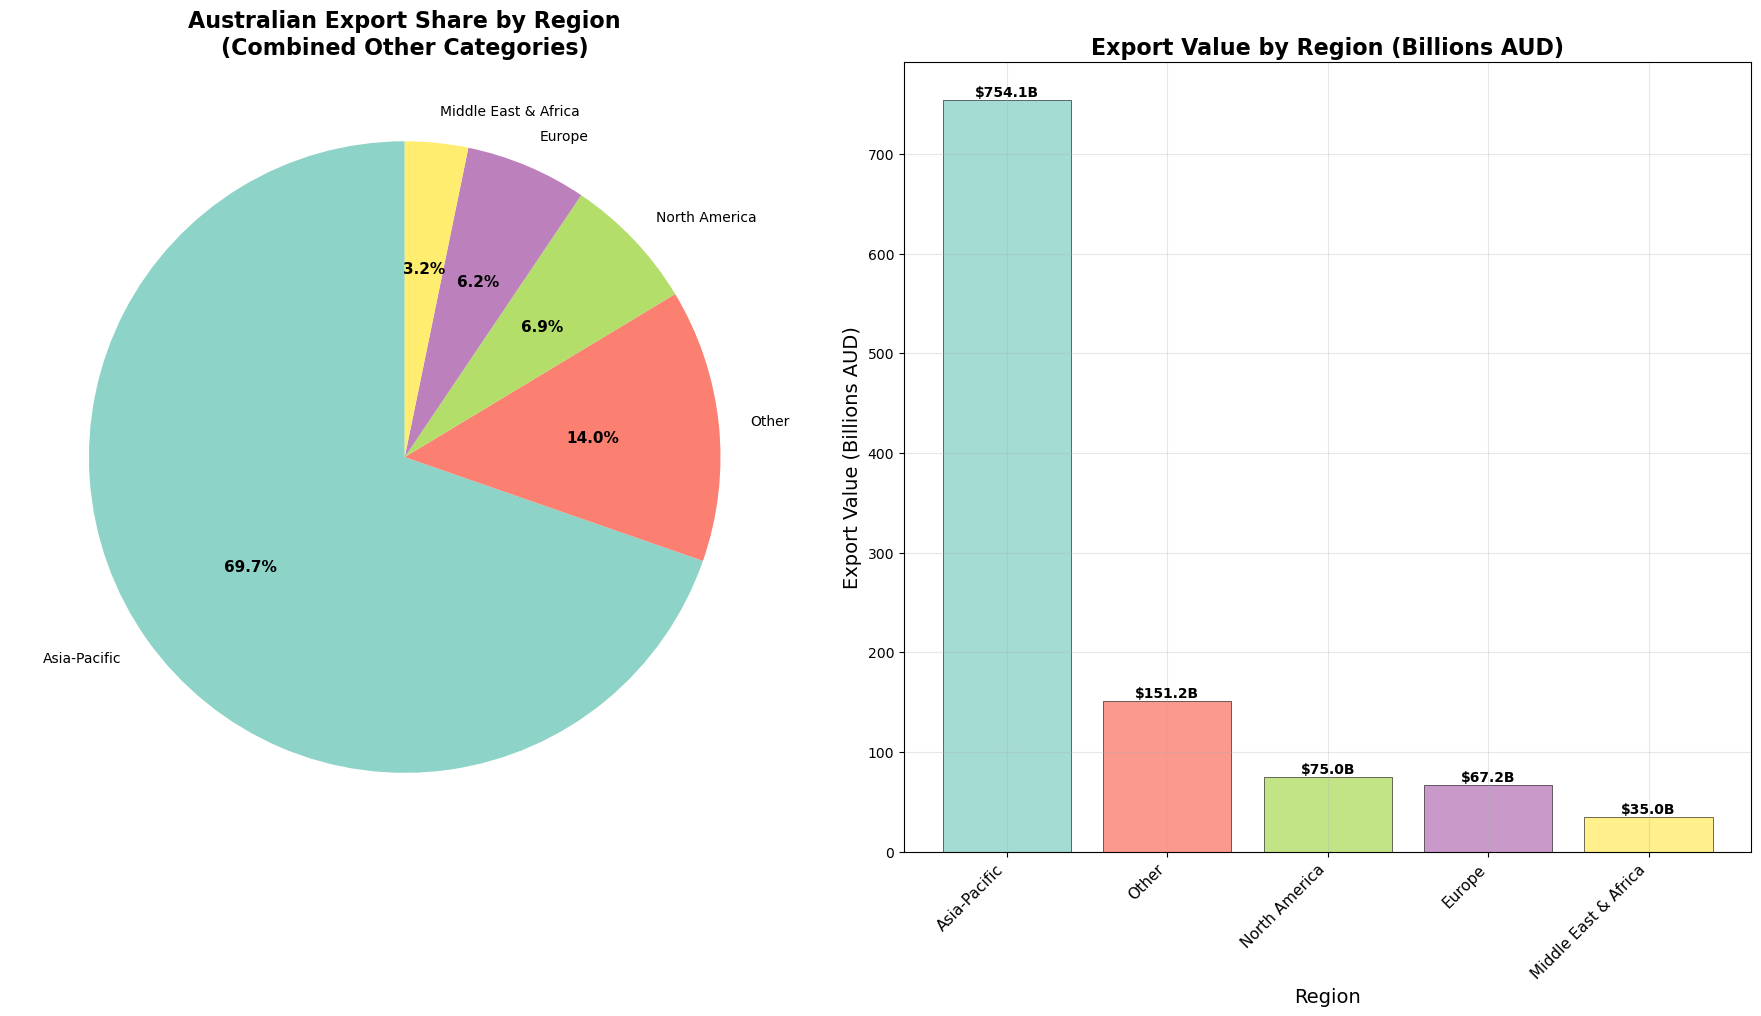


 KEY INSIGHTS:
Top Region: Asia-Pacific (69.7%)
Top 3 regions: 90.6% of exports
Total regions: 5


In [47]:

print("=== EXPORT SHARE BY REGION ANALYSIS ===")

import matplotlib.pyplot as plt
import numpy as np
from region_mapping import add_region_to_dataframe

# 1. APPLY REGIONAL MAPPING
# Add region column to existing dataframe
df = add_region_to_dataframe(df, 'country_of_destination', 'region')

# Check which countries are mapped to "Other"
other_countries = df[df['region'] == 'Other']['country_of_destination'].unique()
if len(other_countries) > 0:
    print(f"\nCountries mapped to 'Other' ({len(other_countries)} countries):")
    for country in sorted(other_countries)[:10]:  # Show first 10
        print(f"   • {country}")
    if len(other_countries) > 10:
        print(f"   ... and {len(other_countries) - 10} more")

# 2. REGIONAL EXPORT SHARE ANALYSIS
regional_analysis = df.groupby('region')['value_fob_aud'].sum().reset_index()
regional_analysis['value_billions'] = regional_analysis['value_fob_aud'] / 1e9
regional_analysis['market_share_pct'] = (regional_analysis['value_fob_aud'] / regional_analysis['value_fob_aud'].sum()) * 100

# Sort by market share
regional_analysis = regional_analysis.sort_values('market_share_pct', ascending=False)

# 3. COMBINE SMALL REGIONS WITH MAIN "OTHER" CATEGORY
small_regions = regional_analysis[regional_analysis['market_share_pct'] <= 1.0]
other_mask = regional_analysis['region'] == 'Other'

if other_mask.any() and len(small_regions) > 0:
    # Add small regions to the main "Other" category
    regional_analysis.loc[other_mask, 'market_share_pct'] += small_regions['market_share_pct'].sum()
    regional_analysis.loc[other_mask, 'value_fob_aud'] += small_regions['value_fob_aud'].sum()
    regional_analysis.loc[other_mask, 'value_billions'] = regional_analysis.loc[other_mask, 'value_fob_aud'] / 1e9
    
    # Remove small regions from the data
    regional_analysis = regional_analysis[~regional_analysis.index.isin(small_regions.index)]
    
    print(f"\nCombined {len(small_regions)} small regions with 'Other' category")
    print(f"Small regions combined: {', '.join(small_regions['region'].tolist())}")

# Re-sort after combining
regional_analysis = regional_analysis.sort_values('market_share_pct', ascending=False)

print(f"\nREGIONAL EXPORT SHARE:")
print("=" * 60)
for i, (_, region) in enumerate(regional_analysis.iterrows(), 1):
    print(f"{i}. {region['region']:<25} {region['market_share_pct']:>6.1f}% (${region['value_billions']:>6.1f}B)")

# 4. REGIONAL VISUALIZATIONS (MATPLOTLIB)
plt.style.use('default')
fig = plt.figure(figsize=(18, 10))

# 4.1 Regional Market Share Pie Chart (Combined Others)
ax1 = plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(regional_analysis)))

wedges, texts, autotexts = ax1.pie(
    regional_analysis['market_share_pct'], 
    labels=regional_analysis['region'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
ax1.set_title('Australian Export Share by Region\n(Combined Other Categories)', fontsize=16, fontweight='bold')
plt.setp(autotexts, size=11, weight='bold')

# 4.2 Regional Value Comparison Bar Chart
ax2 = plt.subplot(1, 2, 2)
bars = ax2.bar(range(len(regional_analysis)), regional_analysis['value_billions'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_title('Export Value by Region (Billions AUD)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Region', fontsize=14)
ax2.set_ylabel('Export Value (Billions AUD)', fontsize=14)
ax2.set_xticks(range(len(regional_analysis)))
ax2.set_xticklabels(regional_analysis['region'], rotation=45, ha='right', fontsize=11)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, regional_analysis['value_billions'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'${value:.1f}B', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. STRATEGIC INSIGHTS
print(f"\n KEY INSIGHTS:")
print("=" * 40)

top_region = regional_analysis.iloc[0]
top_3_share = regional_analysis.head(3)['market_share_pct'].sum()

print(f"Top Region: {top_region['region']} ({top_region['market_share_pct']:.1f}%)")
print(f"Top 3 regions: {top_3_share:.1f}% of exports")
print(f"Total regions: {len(regional_analysis)}")


Australian Export Share by Region (Combined Other Categories)

###### This chart shows how Australia’s exports are distributed across global regions. The Asia–Pacific region dominates, accounting for nearly 70% of total exports, underscoring the region’s central role in Australia’s trade relationships — particularly with major partners such as China, Japan, and South Korea. Other regions like North America (6.9%), Europe (6.1%), and the Middle East & Africa (3.2%) contribute smaller but stable shares, while 14% of exports fall under “Other” destinations, which include emerging markets.

Export Value by Region (Billions AUD)

###### This bar chart highlights the total export value by region. The Asia–Pacific region leads with over $717.9 billion AUD, followed by the ‘Other’ category ($145 billion) and North America ($71.5 billion). Europe and the Middle East & Africa trail behind with $63.2 billion and $33.7 billion respectively.

=== YEAR-OVER-YEAR GROWTH ANALYSIS (Q1 2024 vs Q1 2025) ===
Filtering data for Q1 (January-April) only...
Q1 2024 records: 281,682
Q1 2025 records: 284,723

Calculating YoY growth by destination country...
Countries analyzed: 50 (minimum $100M in Q1 2024)

 TOP 10 FASTEST GROWING MARKETS (Q1 2024 → Q1 2025):
 1. South Africa                               256.4% ($  +1.3B)
    Q1 2024: $0.5B → Q1 2025: $1.8B
 2. Belgium                                    143.4% ($  +1.0B)
    Q1 2024: $0.7B → Q1 2025: $1.7B
 3. Mozambique                                 140.4% ($  +0.2B)
    Q1 2024: $0.2B → Q1 2025: $0.4B
 4. United Kingdom, Channel Islands and Isle   135.0% ($  +1.7B)
    Q1 2024: $1.3B → Q1 2025: $2.9B
 5. United States of America                   102.9% ($ +10.3B)
    Q1 2024: $10.0B → Q1 2025: $20.2B
 6. Pakistan                                    67.4% ($  +0.2B)
    Q1 2024: $0.2B → Q1 2025: $0.4B
 7. Bahrain                                     62.3% ($  +0.4B)
    Q1 2024: $0.6

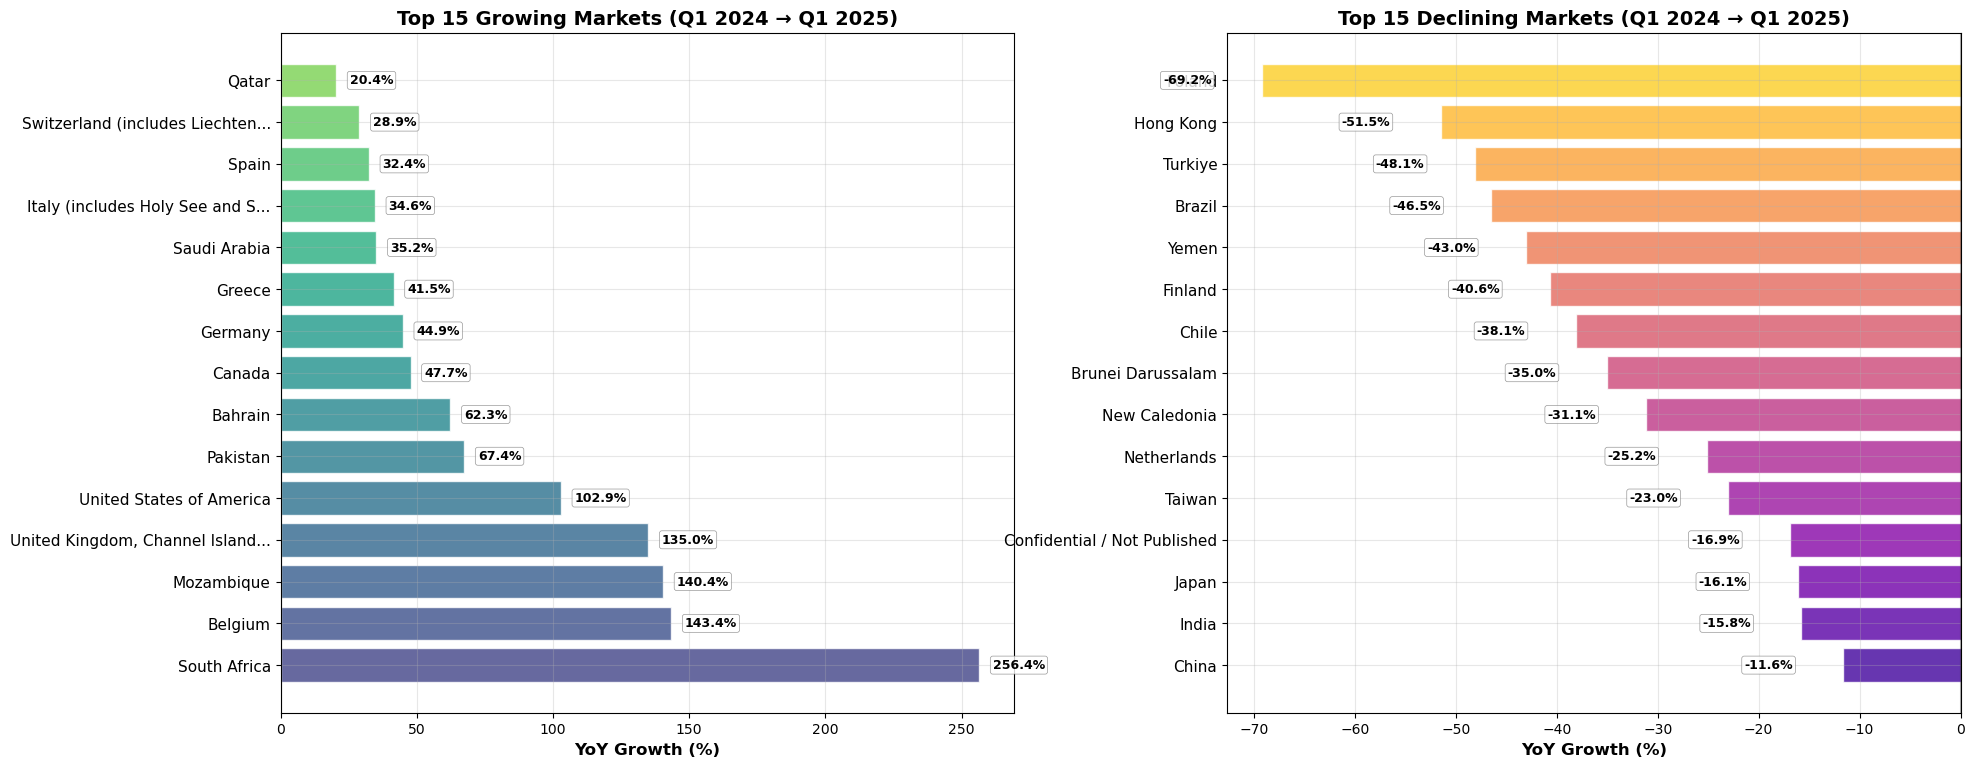


 KEY INSIGHTS:
Major Growth Opportunities (>20% growth, >$500M market):
   • South Africa: 256.4% growth ($0.5B → $1.8B)
   • Belgium: 143.4% growth ($0.7B → $1.7B)
   • United Kingdom, Channel Islands and Isle of Man, nfd: 135.0% growth ($1.3B → $2.9B)
   • United States of America: 102.9% growth ($10.0B → $20.2B)
   • Bahrain: 62.3% growth ($0.6B → $1.0B)

Major Concerns (>20% decline, >$500M market):
   • Taiwan: -23.0% decline ($6.5B → $5.0B)
   • Netherlands: -25.2% decline ($2.0B → $1.5B)
   • Brazil: -46.5% decline ($0.8B → $0.4B)
   • Hong Kong: -51.5% decline ($5.9B → $2.9B)

 YoY Growth Analysis completed!


In [48]:
# YEAR-OVER-YEAR (YOY) GROWTH ANALYSIS - Q1 2024 vs Q1 2025
print("=== YEAR-OVER-YEAR GROWTH ANALYSIS (Q1 2024 vs Q1 2025) ===")



# 1. FILTER DATA FOR Q1 (JANUARY-APRIL) ONLY
print("Filtering data for Q1 (January-April) only...")

# Filter for Q1 months (January, February, March, April)
q1_months = ['January', 'February', 'March', 'April']
df_q1 = df[df['month'].isin(q1_months)].copy()

print(f"Q1 2024 records: {len(df_q1[df_q1['year'] == 2024]):,}")
print(f"Q1 2025 records: {len(df_q1[df_q1['year'] == 2025]):,}")

# 2. CALCULATE YOY GROWTH BY COUNTRY
print("\nCalculating YoY growth by destination country...")

# Calculate export values by country and year for Q1 only
country_yearly = df_q1.groupby(['country_of_destination', 'year'])['value_fob_aud'].sum().unstack(fill_value=0)

# Calculate YoY growth
if 2024 in country_yearly.columns and 2025 in country_yearly.columns:
    country_yearly['YoY_Growth_%'] = ((country_yearly[2025] - country_yearly[2024]) / country_yearly[2024] * 100).round(2)
    country_yearly['YoY_Growth_Absolute'] = (country_yearly[2025] - country_yearly[2024]) / 1e9  # in billions
    country_yearly['Q1_2024_Value'] = country_yearly[2024] / 1e9  # in billions
    country_yearly['Q1_2025_Value'] = country_yearly[2025] / 1e9  # in billions
    
    # Filter countries with significant trade volume (at least $100M in Q1 2024)
    significant_countries = country_yearly[country_yearly[2024] >= 1e8].copy()  # $100M threshold
    
    # Sort by YoY growth
    significant_countries = significant_countries.sort_values('YoY_Growth_%', ascending=False)
    
    print(f"Countries analyzed: {len(significant_countries)} (minimum $100M in Q1 2024)")
    
    # 3. TOP GROWING MARKETS
    print(f"\n TOP 10 FASTEST GROWING MARKETS (Q1 2024 → Q1 2025):")
    print("=" * 80)
    for i, (country, row) in enumerate(significant_countries.head(10).iterrows(), 1):
        growth_pct = row['YoY_Growth_%']
        growth_abs = row['YoY_Growth_Absolute']
        value_2024 = row['Q1_2024_Value']
        value_2025 = row['Q1_2025_Value']
        
        if growth_pct > 0:
            emoji = ""
        else:
            emoji = ""
            
        print(f"{i:2d}. {country[:40]:<40} {emoji} {growth_pct:>6.1f}% (${growth_abs:>+6.1f}B)")
        print(f"    Q1 2024: ${value_2024:.1f}B → Q1 2025: ${value_2025:.1f}B")
    
    # 4. TOP DECLINING MARKETS
    print(f"\nTOP 10 DECLINING MARKETS (Q1 2024 → Q1 2025):")
    print("=" * 80)
    declining_countries = significant_countries.tail(10).sort_values('YoY_Growth_%', ascending=True)
    for i, (country, row) in enumerate(declining_countries.iterrows(), 1):
        growth_pct = row['YoY_Growth_%']
        growth_abs = row['YoY_Growth_Absolute']
        value_2024 = row['Q1_2024_Value']
        value_2025 = row['Q1_2025_Value']
        
        print(f"{i:2d}. {country[:40]:<40}  {growth_pct:>6.1f}% (${growth_abs:>+6.1f}B)")
        print(f"    Q1 2024: ${value_2024:.1f}B → Q1 2025: ${value_2025:.1f}B")
    
    # 5. GROWTH SUMMARY STATISTICS
    avg_growth = significant_countries['YoY_Growth_%'].mean()
    positive_growth = (significant_countries['YoY_Growth_%'] > 0).sum()
    total_countries = len(significant_countries)
    
    print(f"\n GROWTH SUMMARY (Q1 2024 → Q1 2025):")
    print("=" * 50)
    print(f" Average YoY Growth: {avg_growth:.1f}%")
    print(f" Countries with Positive Growth: {positive_growth}/{total_countries} ({positive_growth/total_countries*100:.1f}%)")
    print(f" Countries with Negative Growth: {total_countries-positive_growth}/{total_countries} ({(total_countries-positive_growth)/total_countries*100:.1f}%)")
    
    # 6. VISUALIZATIONS
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    
    # 6.1 Top 15 Growing Markets with Cool Colors
    top_growing = significant_countries.head(15)
    # Use a cool gradient from electric blue to neon green
    growing_colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_growing)))
    
    bars1 = ax1.barh(range(len(top_growing)), top_growing['YoY_Growth_%'], color=growing_colors, alpha=0.8, edgecolor='white', linewidth=1)
    ax1.set_yticks(range(len(top_growing)))
    ax1.set_yticklabels([country[:30] + '...' if len(country) > 30 else country for country in top_growing.index], fontsize=11)
    ax1.set_xlabel('YoY Growth (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Top 15 Growing Markets (Q1 2024 → Q1 2025)', fontsize=14, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels with better positioning
    for i, (bar, value) in enumerate(zip(bars1, top_growing['YoY_Growth_%'])):
        # Position labels further from the bars to avoid truncation
        x_pos = value + (5 if value > 0 else -5)  # Increased offset
        ax1.text(x_pos, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}%', ha='left' if value > 0 else 'right', va='center', 
                fontsize=9, fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', 
                facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5))
    
    # 6.2 Top 15 Declining Markets with Cool Colors
    top_declining = significant_countries.tail(15)
    
    # Debug: Print the actual country names to see what we're working with
    print("\nDEBUG - Top 15 Declining Markets:")
    for i, country in enumerate(top_declining.index):
        print(f"{i+1}. '{country}' (length: {len(country)})")
    # Use a cool gradient from deep purple to hot pink
    declining_colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(top_declining)))
    
    bars2 = ax2.barh(range(len(top_declining)), top_declining['YoY_Growth_%'], color=declining_colors, alpha=0.8, edgecolor='white', linewidth=1)
    ax2.set_yticks(range(len(top_declining)))
    ax2.set_yticklabels([country[:30] + '...' if len(country) > 30 else country for country in top_declining.index], fontsize=11)
    ax2.set_xlabel('YoY Growth (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Top 15 Declining Markets (Q1 2024 → Q1 2025)', fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels with better positioning
    for i, (bar, value) in enumerate(zip(bars2, top_declining['YoY_Growth_%'])):
        # Position labels further from the bars to avoid truncation
        x_pos = value + (-5 if value < 0 else 5)  # Increased offset
        ax2.text(x_pos, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}%', ha='right' if value < 0 else 'left', va='center', 
                fontsize=9, fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', 
                facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5))
    
    # Adjust layout to ensure all country names are visible
    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.1)  # More space on left for country names
    plt.show()
    
    # 7. KEY INSIGHTS
    print(f"\n KEY INSIGHTS:")
    print("=" * 40)
    
    # Find biggest growth opportunities
    big_growers = significant_countries[
        (significant_countries['YoY_Growth_%'] > 20) & 
        (significant_countries['Q1_2024_Value'] > 0.5)  # >$500M in 2024
    ].head(5)
    
    if len(big_growers) > 0:
        print(f"Major Growth Opportunities (>20% growth, >$500M market):")
        for country, row in big_growers.iterrows():
            print(f"   • {country}: {row['YoY_Growth_%']:.1f}% growth (${row['Q1_2024_Value']:.1f}B → ${row['Q1_2025_Value']:.1f}B)")
    
    # Find biggest concerns
    big_decliners = significant_countries[
        (significant_countries['YoY_Growth_%'] < -20) & 
        (significant_countries['Q1_2024_Value'] > 0.5)  # >$500M in 2024
    ].head(5)
    
    if len(big_decliners) > 0:
        print(f"\nMajor Concerns (>20% decline, >$500M market):")
        for country, row in big_decliners.iterrows():
            print(f"   • {country}: {row['YoY_Growth_%']:.1f}% decline (${row['Q1_2024_Value']:.1f}B → ${row['Q1_2025_Value']:.1f}B)")
    
    print(f"\n YoY Growth Analysis completed!")
    
else:
    print(" Cannot calculate YoY growth - missing 2024 or 2025 data")
    print(f"Available years: {sorted(df_q1['year'].unique())}")

##### For the quarterly analysis, we compared Q1 2024 against Q1 2025.

###### This section helps us understand where Australian exports are increasing and where they are falling, both quarter-to-quarter (Q1 2024 → Q1 2025) 

###### This gives a clean, equal, and like-for-like comparison because both periods cover the same three months.

###### This section highlights short-term market changes and helps us understand which countries are growing or declining at the very beginning of the year. These insights complement the year-to-date analysis by showing immediate shifts that may not yet be visible in longer-term data.”

=== YEAR-OVER-YEAR GROWTH ANALYSIS BY COUNTRY ===
Countries analyzed: 33 (minimum $1B in 2024)

 TOP 10 FASTEST GROWING MARKETS:
 1. United Kingdom, Channel Islands and Isle    48.0% ($  +5.0B)
    2024: $10.4B → 2025: $15.4B
 2. South Africa                                24.8% ($  +0.6B)
    2024: $2.2B → 2025: $2.8B
 3. United States of America                    10.7% ($  +3.4B)
    2024: $31.9B → 2025: $35.4B
 4. Belgium                                      8.9% ($  +0.2B)
    2024: $2.1B → 2025: $2.3B
 5. Switzerland (includes Liechtenstein)        -4.0% ($  -0.1B)
    2024: $2.1B → 2025: $2.0B
 6. Saudi Arabia                                -4.5% ($  -0.1B)
    2024: $1.1B → 2025: $1.1B
 7. Canada                                      -6.0% ($  -0.2B)
    2024: $3.2B → 2025: $3.0B
 8. Bahrain                                    -20.6% ($  -0.5B)
    2024: $2.3B → 2025: $1.8B
 9. New Zealand                                -21.2% ($  -2.8B)
    2024: $13.2B → 2025: $10.4B
10. Papua 

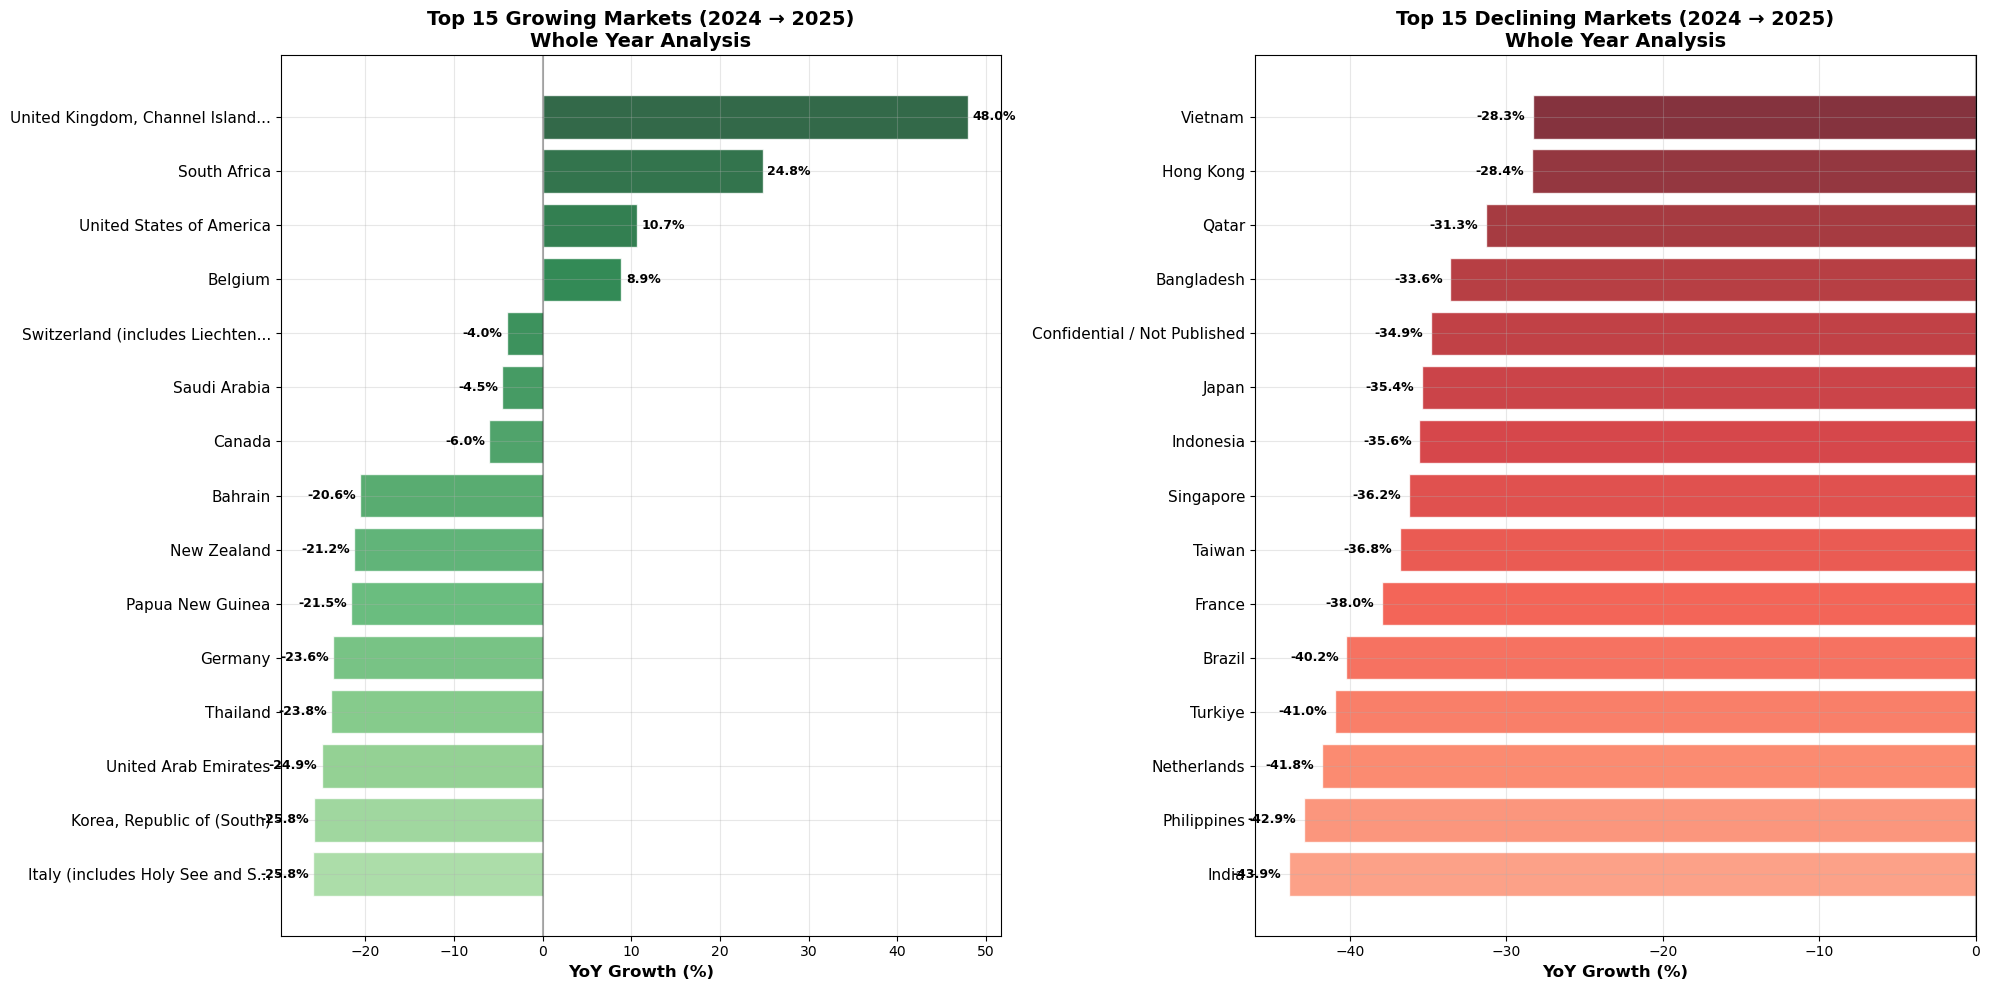


 GROWTH SUMMARY:
   Average YoY Growth: -22.4%
   Countries with Positive Growth: 4/33 (12.1%)
   Countries with Negative Growth: 29/33 (87.9%)
 YoY Growth Analysis completed!


In [49]:
# YOY GROWTH ANALYSIS BY COUNTRY (2024 → 2025)
print("=== YEAR-OVER-YEAR GROWTH ANALYSIS BY COUNTRY ===")

# Calculate export values by country and year
country_yearly = df.groupby(['country_of_destination', 'year'])['value_fob_aud'].sum().unstack(fill_value=0)

# Calculate YoY growth
if 2024 in country_yearly.columns and 2025 in country_yearly.columns:
    country_yearly['YoY_Growth_%'] = ((country_yearly[2025] - country_yearly[2024]) / country_yearly[2024] * 100).round(2)
    country_yearly['YoY_Growth_Absolute'] = (country_yearly[2025] - country_yearly[2024]) / 1e9  # in billions
    
    # Filter countries with significant trade volume (at least $1B in 2024)
    significant_countries = country_yearly[country_yearly[2024] >= 1e9].copy()
    
    # Sort by YoY growth
    significant_countries = significant_countries.sort_values('YoY_Growth_%', ascending=False)
    
    print(f"Countries analyzed: {len(significant_countries)} (minimum $1B in 2024)")
    print("\n TOP 10 FASTEST GROWING MARKETS:")
    print("=" * 80)
    for i, (country, row) in enumerate(significant_countries.head(10).iterrows(), 1):
        growth_pct = row['YoY_Growth_%']
        growth_abs = row['YoY_Growth_Absolute']
        value_2024 = row[2024] / 1e9
        value_2025 = row[2025] / 1e9
        
        if growth_pct > 0:
            emoji = ""
        else:
            emoji = ""
            
        print(f"{i:2d}. {country[:40]:<40} {emoji} {growth_pct:>6.1f}% (${growth_abs:>+6.1f}B)")
        print(f"    2024: ${value_2024:.1f}B → 2025: ${value_2025:.1f}B")
    
    print("\n TOP 10 DECLINING MARKETS:")
    print("=" * 80)
    declining_countries = significant_countries.tail(10).sort_values('YoY_Growth_%', ascending=True)
    for i, (country, row) in enumerate(declining_countries.iterrows(), 1):
        growth_pct = row['YoY_Growth_%']
        growth_abs = row['YoY_Growth_Absolute']
        value_2024 = row[2024] / 1e9
        value_2025 = row[2025] / 1e9
        
        print(f"{i:2d}. {country[:40]:<40}  {growth_pct:>6.1f}% (${growth_abs:>+6.1f}B)")
        print(f"    2024: ${value_2024:.1f}B → 2025: ${value_2025:.1f}B")
    

    # Create visualizations for top growing and declining markets (Whole Year)
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Prepare data for top 15 growing markets
    top_growing = significant_countries.head(15).copy()
    top_growing = top_growing.sort_values('YoY_Growth_%', ascending=True)  # Sort ascending for horizontal bar chart
    
    # Prepare data for top 15 declining markets
    top_declining = significant_countries.tail(15).copy()
    top_declining = top_declining.sort_values('YoY_Growth_%', ascending=True)  # Sort ascending for horizontal bar chart
    
    # Create figure with two subplots
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Color schemes
    growing_colors = plt.cm.Greens(np.linspace(0.4, 1, len(top_growing)))
    declining_colors = plt.cm.Reds(np.linspace(0.4, 1, len(top_declining)))
    
    # Chart 1: Top 15 Growing Markets (Whole Year)
    bars1 = ax1.barh(range(len(top_growing)), top_growing['YoY_Growth_%'], color=growing_colors, alpha=0.8, edgecolor='white', linewidth=1)
    ax1.set_yticks(range(len(top_growing)))
    ax1.set_yticklabels([country[:30] + '...' if len(country) > 30 else country for country in top_growing.index], fontsize=11)
    ax1.set_xlabel('YoY Growth (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Top 15 Growing Markets (2024 → 2025)\nWhole Year Analysis', fontsize=14, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for idx, (bar, value) in enumerate(zip(bars1, top_growing['YoY_Growth_%'])):
        width = bar.get_width()
        label_x = width + (0.5 if width >= 0 else -0.5)
        ax1.text(label_x, idx, f'{value:.1f}%', 
                va='center', ha='left' if width >= 0 else 'right', 
                fontsize=9, fontweight='bold')
    
    # Chart 2: Top 15 Declining Markets (Whole Year)
    bars2 = ax2.barh(range(len(top_declining)), top_declining['YoY_Growth_%'], color=declining_colors, alpha=0.8, edgecolor='white', linewidth=1)
    ax2.set_yticks(range(len(top_declining)))
    ax2.set_yticklabels([country[:30] + '...' if len(country) > 30 else country for country in top_declining.index], fontsize=11)
    ax2.set_xlabel('YoY Growth (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Top 15 Declining Markets (2024 → 2025)\nWhole Year Analysis', fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for idx, (bar, value) in enumerate(zip(bars2, top_declining['YoY_Growth_%'])):
        width = bar.get_width()
        label_x = width + (-0.5 if width < 0 else 0.5)
        ax2.text(label_x, idx, f'{value:.1f}%', 
                va='center', ha='right' if width < 0 else 'left', 
                fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    avg_growth = significant_countries['YoY_Growth_%'].mean()
    positive_growth = (significant_countries['YoY_Growth_%'] > 0).sum()
    total_countries = len(significant_countries)
    
    print(f"\n GROWTH SUMMARY:")
    print(f"   Average YoY Growth: {avg_growth:.1f}%")
    print(f"   Countries with Positive Growth: {positive_growth}/{total_countries} ({positive_growth/total_countries*100:.1f}%)")
    print(f"   Countries with Negative Growth: {total_countries-positive_growth}/{total_countries} ({(total_countries-positive_growth)/total_countries*100:.1f}%)")

else:
    print(" Cannot calculate YoY growth - missing 2024 or 2025 data")
    print(f"Available years: {sorted(df['year'].unique())}")

print(" YoY Growth Analysis completed!")

##### Year-to-Date (Full 2024 → Jan–Sep 2025) Growth Analysis

###### This section helps us understand where Australian exports are increasing and where they are falling, year-over-date (2024 → 2025).For the year-to-date analysis, we compared the full 12-month export data for 2024 with the available 2025 data from January to September.Since 2025 is still ongoing, these results do not represent the full year. Instead, they show how each market is performing so far in 2025.

###### This method helps us identify early trends  markets that are gaining momentum and markets that are slowing down even before the final 2025 numbers are released. Once the remaining months (Oct–Dec 2025) become available, we will update the analysis to reflect the complete year.